# DGD Training Demo: Using the DGDTrainer Class

This notebook demonstrates the complete usage of the DGDTrainer class from `src/training/trainer.py`. We'll train a Deep Generative Decoder (DGD) model on the FashionMNIST dataset using the standard production configuration, showcasing:

- Configuration setup using Hydra/OmegaConf with the standard config
- Dataset preparation and data loading
- ClearML integration for experiment tracking
- Model training with representation layers and GMM fitting
- Visualization of training progress and results
- Model evaluation and sample generation
- Model saving and loading

The DGD model combines:
- **Representation Layer**: Learnable per-sample embeddings in latent space
- **Convolutional Decoder**: Neural network that maps latent codes to images
- **Gaussian Mixture Model**: Probabilistic model fitted to the learned representations

**Note**: This demo uses the standard production configuration for full model capacity. If you have limited GPU memory, you can uncomment the memory optimization lines in the configuration section.

## 1. Setup Environment and Imports

First, let's import all necessary libraries and set up the environment.

In [1]:
# Standard library imports
import os
import sys
import time
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Data science and ML libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms

# Configuration management
from omegaconf import DictConfig, OmegaConf
import hydra
from hydra import initialize, compose

# Experiment tracking
from clearml import Task

# Add project root to path for imports
current_dir = Path.cwd()
if 'notebooks' in current_dir.parts:
    # We're in the notebooks folder, go up one level
    project_root = current_dir.parent
else:
    project_root = current_dir

sys.path.append(str(project_root))
sys.path.append(str(project_root / 'src'))

# Import our custom modules
from src.training.trainer import DGDTrainer
from src.data.dataloader import create_dataloaders, get_sample_batches
from src.models import RepresentationLayer, DGD, ConvDecoder, GaussianMixture
from src.visualization import plot_training_losses, plot_images

# Set device and apply memory optimizations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Apply CUDA memory optimizations for local training
if torch.cuda.is_available():
    # Clear GPU cache
    torch.cuda.empty_cache()
    
    # Set memory management optimizations
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
    
    # Enable memory-efficient attention if available
    try:
        torch.backends.cuda.enable_flash_sdp(False)  # Disable for compatibility
    except:
        pass
    
    print(f"✓ GPU: {torch.cuda.get_device_name()}")
    print(f"✓ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"✓ Applied CUDA memory optimizations")

if device.type == 'cuda':
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
        print(f"  Memory Allocated: {torch.cuda.memory_allocated(i)/1024**2} MB")
        print(f"  Memory Reserved: {torch.cuda.memory_reserved(i)/1024**2} MB")
        print(f"  Total Memory: {torch.cuda.get_device_properties(i).total_memory/1024**2} MB")
    device = torch.device('cuda:1')
    torch.cuda.set_device(device)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)


try:
    from cuml.accel import install
    install()
except ImportError:
    print("Cuml not installed, using CPU for umap and sklearn")


print("✓ All imports successful!")
print(f"✓ Project root: {project_root}")
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")
print("✓ Memory optimizations applied for local training")

Using device: cuda
✓ GPU: NVIDIA A30
✓ GPU Memory: 25.3 GB
✓ Applied CUDA memory optimizations
Number of CUDA devices: 2
Device 0: NVIDIA A30
  Memory Allocated: 0.0 MB
  Memory Reserved: 0.0 MB
  Total Memory: 24165.25 MB
Device 1: NVIDIA A30
  Memory Allocated: 0.0 MB
  Memory Reserved: 0.0 MB
  Total Memory: 24165.25 MB
cuML: Installed accelerator for sklearn.
cuML: Installed accelerator for umap.
cuML: Successfully initialized accelerator.
✓ All imports successful!
✓ Project root: /maps/projects/heads/people/kbh904/ImageDGD
✓ PyTorch version: 2.7.0+cu128
✓ CUDA available: True
✓ Memory optimizations applied for local training


## 2. Load Configuration

Load the training configuration using Hydra/OmegaConf. We'll use the standard production configuration which provides full model capacity and training settings. You can optionally apply memory optimizations if running on limited hardware.

In [2]:
# Load configuration from the config directory
config_dir = project_root / "config"
print(f"Loading configuration from: {config_dir}")

# For Hydra initialize, we need to provide a relative path from the current working directory
# Since we're in the notebooks folder, the config folder is ../config
relative_config_path = "../config"

# Initialize Hydra with the relative config directory
with initialize(version_base=None, config_path=relative_config_path):
    # Use the standard config for full training capabilities
    config = compose(config_name="config")

print("✓ Configuration loaded successfully!")
print(f"✓ Experiment: {config.experiment_name}")
print(f"✓ Dataset: {config.data.dataset}")
print(f"✓ Training epochs: {config.training.epochs}")
print(f"✓ Batch size: {config.data.batch_size}")
print(f"✓ Latent dimensions: {config.model.representation.n_features}")

# Optional: Apply some memory optimizations for local training if needed
print("\n🔧 Optional memory optimizations (uncomment if needed for limited GPU memory)...")

# Uncomment these lines if you need to reduce memory usage:
# config.data.batch_size = 64  # Reduce batch size
# config.data.subset_fraction = 0.2  # Use subset of data
# config.training.epochs = 50  # Fewer epochs
# config.model.decoder.hidden_dims = [256, 128, 64]  # Smaller network
# config.model.representation.n_features = 16   # Smaller latent space
# config.model.gmm.n_components = 5  # Fewer GMM components
# config.training.logging.save_figures = False  # Save memory

print("✓ Using standard configuration:")
print(f"  - Batch size: {config.data.batch_size}")
print(f"  - Data subset: {'Yes' if config.data.use_subset else 'No'} ({config.data.subset_fraction:.1%} if subset)")
print(f"  - Epochs: {config.training.epochs}")
print(f"  - Latent dims: {config.model.representation.n_features}")
print(f"  - Decoder dims: {list(config.model.decoder.hidden_dims)}")
print(f"  - GMM components: {config.model.gmm.n_components}")

# Display key configuration sections
print("\n🔧 Model Configuration:")
print(f"  Representation: {config.model.representation.distribution} distribution")
print(f"  Latent dims: {config.model.representation.n_features}")
print(f"  Decoder hidden dims: {list(config.model.decoder.hidden_dims)}")
print(f"  GMM components: {config.model.gmm.n_components}")
print(f"  Output size: {config.model.decoder.output_size}")

print("\n🎯 Training Configuration:")
print(f"  Decoder optimizer: {config.training.optimizer.decoder.type}")
print(f"  Representation optimizer: {config.training.optimizer.representation.type}")
print(f"  Learning rates: decoder={config.training.optimizer.decoder.lr}, rep={config.training.optimizer.representation.lr}")
print(f"  GMM starts at epoch: {config.training.first_epoch_gmm}")
print(f"  Refit GMM interval: {config.training.refit_gmm_interval}")
print(f"  Lambda GMM: {config.training.lambda_gmm}")

print("\n📊 Data Configuration:")
print(f"  Dataset: {config.data.dataset}")
print(f"  Batch size: {config.data.batch_size}")
print(f"  Use subset: {config.data.use_subset}")
print(f"  Subset fraction: {config.data.subset_fraction}")
print(f"  Number of workers: {config.data.num_workers}")

print("\n💾 Using Standard Production Configuration:")
print("  ✓ Full dataset (unless subset enabled)")
print("  ✓ Larger model architecture")
print("  ✓ More training epochs")
print("  ✓ More GMM components")
print("  ✓ Production-ready settings")
print("  ✓ Better model capacity and performance")

Loading configuration from: /maps/projects/heads/people/kbh904/ImageDGD/config
✓ Configuration loaded successfully!
✓ Experiment: ImageDGD_Default
✓ Dataset: FashionMNIST
✓ Training epochs: 200
✓ Batch size: 128
✓ Latent dimensions: 5

🔧 Optional memory optimizations (uncomment if needed for limited GPU memory)...
✓ Using standard configuration:
  - Batch size: 128
  - Data subset: No (100.0% if subset)
  - Epochs: 200
  - Latent dims: 5
  - Decoder dims: [128, 64, 32]
  - GMM components: 20

🔧 Model Configuration:
  Representation: uniform_sphere distribution
  Latent dims: 5
  Decoder hidden dims: [128, 64, 32]
  GMM components: 20
  Output size: [28, 28]

🎯 Training Configuration:
  Decoder optimizer: AdamW
  Representation optimizer: AdamW
  Learning rates: decoder=0.001, rep=0.01
  GMM starts at epoch: 50
  Refit GMM interval: 50
  Lambda GMM: 1.0

📊 Data Configuration:
  Dataset: FashionMNIST
  Batch size: 128
  Use subset: False
  Subset fraction: 1.0
  Number of workers: 4

💾 U

## 3. Prepare Dataset and Data Loaders

Load and prepare the FashionMNIST dataset with proper transformations and create data loaders.

Data directory: /maps/projects/heads/people/kbh904/ImageDGD/data
✓ Configuration updated for FashionMNIST dataset
Loading dataset and creating data loaders...
✓ Train loader: 468 batches
✓ Test loader: 79 batches
✓ Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
✓ Prepared sample data for visualization


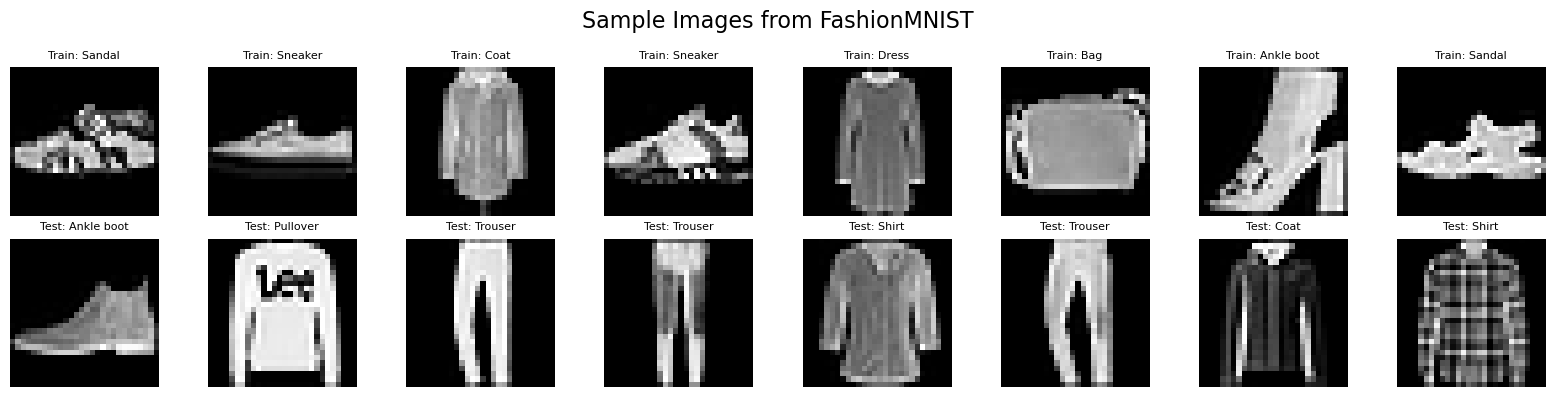


📊 Dataset Summary:
  Input shape: torch.Size([1, 28, 28])
  Number of classes: 10
  Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
  Sample data shapes: train=16, test=16
  Value range: [-1.00, 1.00] (normalized to [-1,1])


In [3]:
# Create data directories
data_dir = project_root / "data"
data_dir.mkdir(exist_ok=True)

print(f"Data directory: {data_dir}")

# OmegaConf is in struct mode, so we need to disable it to add new fields
OmegaConf.set_struct(config, False)  # Disable struct mode temporarily

# Update the config to work with the dataloader function
config.data.data_dir = str(data_dir)
config.data.download = True

# Define class names for FashionMNIST
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# Update the class names in config
config.data.class_names = class_names

# Re-enable struct mode if desired
OmegaConf.set_struct(config, True)

print("✓ Configuration updated for FashionMNIST dataset")

# Create data loaders using our custom dataloader function
print("Loading dataset and creating data loaders...")
train_loader, test_loader, loaded_class_names = create_dataloaders(config)

print(f"✓ Train loader: {len(train_loader)} batches")
print(f"✓ Test loader: {len(test_loader)} batches")
print(f"✓ Classes: {loaded_class_names}")

# Prepare sample data for visualization using the new function
sample_data = get_sample_batches(train_loader, test_loader, n_samples=16)
print(f"✓ Prepared sample data for visualization")

# Visualize some samples
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
fig.suptitle('Sample Images from FashionMNIST', fontsize=16)

for i in range(8):
    # Train samples
    img = sample_data[1][i].squeeze()
    label = sample_data[2][i].item()
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title(f'Train: {class_names[label]}', fontsize=8)
    axes[0, i].axis('off')
    
    # Test samples  
    img = sample_data[4][i].squeeze()
    label = sample_data[5][i].item()
    axes[1, i].imshow(img, cmap='gray')
    axes[1, i].set_title(f'Test: {class_names[label]}', fontsize=8)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print("\n📊 Dataset Summary:")
print(f"  Input shape: {sample_data[1][0].shape}")
print(f"  Number of classes: {len(class_names)}")
print(f"  Classes: {class_names}")
print(f"  Sample data shapes: train={len(sample_data[1])}, test={len(sample_data[4])}")
print(f"  Value range: [{sample_data[1].min():.2f}, {sample_data[1].max():.2f}] (normalized to [-1,1])")

## 4. Initialize ClearML Task

Set up ClearML for experiment tracking. This will log all training metrics, configurations, and artifacts.

In [4]:
# Initialize ClearML task for experiment tracking
print("Initializing ClearML task...")

try:
    # Create a task for this training session
    task = Task.init(
        project_name="ImageDGD", 
        task_name=f"DGD Training Demo - {config.model.representation.distribution}",
        tags=["demo", "notebook", config.data.dataset, f"{config.training.epochs}epochs"]
    )
    
    # Connect the configuration to ClearML
    task.connect(config)
    
    # Set task description
    task.set_comment("""
    DGD Training Demo using DGDTrainer class.
    
    This experiment demonstrates:
    - Deep Generative Decoder training
    - Representation layer learning
    - GMM fitting in latent space
    - Training visualization and monitoring
    """)
    
    print("✓ ClearML task initialized successfully!")
    print(f"✓ Project: ImageDGD")
    print(f"✓ Task: DGD Training Demo - {config.model.representation.distribution}")
    print(f"✓ Task ID: {task.id}")
    
    # Get dataset sizes from the data loaders
    train_dataset_size = len(train_loader.dataset)
    test_dataset_size = len(test_loader.dataset)
    
    # Log some initial parameters
    task.set_parameters({
        "dataset_size_train": train_dataset_size,
        "dataset_size_test": test_dataset_size,
        "device": str(device),
        "pytorch_version": torch.__version__,
        "subset_used": config.data.use_subset,
        "subset_fraction": config.data.subset_fraction if config.data.use_subset else None
    })
    
except Exception as e:
    print(f"⚠️ ClearML initialization failed: {e}")
    print("⚠️ Continuing without ClearML tracking...")
    task = None

print("\\n📝 Experiment Configuration:")
print(f"  Project: ImageDGD")
print(f"  Task: DGD Training Demo")
print(f"  Dataset: {config.data.dataset}")
print(f"  Model: DGD (Deep Generative Decoder)")  # Fixed: removed non-existent config.model.type
print(f"  Distribution: {config.model.representation.distribution}")
print(f"  Device: {device}")
print(f"  Tracking: {'ClearML' if task else 'Local only'}")

Initializing ClearML task...
ClearML Task: overwriting (reusing) task id=c44459377d064d9db8e9a9d36c38b76f
2025-09-15 16:49:42,721 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.clear.ml/projects/8de4d7e9e1b94bb1b2bafe93c09b2c0b/experiments/c44459377d064d9db8e9a9d36c38b76f/output/log
✓ ClearML task initialized successfully!
✓ Project: ImageDGD
✓ Task: DGD Training Demo - uniform_sphere
✓ Task ID: c44459377d064d9db8e9a9d36c38b76f
\n📝 Experiment Configuration:
  Project: ImageDGD
  Task: DGD Training Demo
  Dataset: FashionMNIST
  Model: DGD (Deep Generative Decoder)
  Distribution: uniform_sphere
  Device: cuda:1
  Tracking: ClearML


2025-09-15 16:50:06,347 - clearml.storage - INFO - Uploading: 7.53MB from /tmp/tmp_95458bo.png


█████████████████████████████████ 100% | 7.53/7.53 MB [00:00<00:00, 19.14MB/s]: 


2025-09-15 16:51:43,957 - clearml.storage - INFO - Uploading: 6.82MB from /tmp/tmpeshr4jkw.png


█████████████████████████████████ 100% | 6.82/6.82 MB [00:00<00:00, 20.60MB/s]: 


2025-09-15 16:52:46,362 - clearml.storage - INFO - Uploading: 8.44MB from /tmp/tmpsh1_94sf.png


█████████████████████████████████ 100% | 8.44/8.44 MB [00:00<00:00, 15.73MB/s]: 


## 5. Create and Configure Trainer

Now let's instantiate the DGDTrainer with our configuration and device settings.

In [5]:
# Create the DGDTrainer instance
print("Creating DGDTrainer...")

trainer = DGDTrainer(
    config=config,
    device=device,
    verbose=True  # Enable detailed logging
)

print("✓ DGDTrainer created successfully!")

# The trainer will automatically handle:
# - Model component creation (decoder, representation layers, GMM)
# - Optimizer setup based on configuration
# - Loss computation and tracking
# - Visualization generation
# - ClearML logging integration

print("\\n🔧 Trainer Configuration:")
print(f"  Device: {trainer.device}")
print(f"  Verbose mode: {trainer.verbose}")
print(f"  Training config: {trainer.training_config.epochs} epochs")
print(f"  GMM starts at epoch: {trainer.training_config.first_epoch_gmm}")
print(f"  Lambda GMM: {trainer.training_config.lambda_gmm}")
print(f"  Log interval: {trainer.training_config.logging.log_interval}")
print(f"  Plot interval: {trainer.training_config.logging.plot_interval}")
print(f"  Save figures: {trainer.training_config.logging.save_figures}")

print("\\n📊 Optimizer Configuration:")
print(f"  Decoder optimizer: {config.training.optimizer.decoder.type}")
print(f"    - Learning rate: {config.training.optimizer.decoder.lr}")
print(f"    - Weight decay: {config.training.optimizer.decoder.weight_decay}")
print(f"  Representation optimizer: {config.training.optimizer.representation.type}")
print(f"    - Learning rate: {config.training.optimizer.representation.lr}")
print(f"    - Weight decay: {config.training.optimizer.representation.weight_decay}")

print("\\n🏗️ Model Architecture:")
print(f"  Representation dimension: {config.model.representation.n_features}")
print(f"  Distribution type: {config.model.representation.distribution}")
print(f"  Decoder hidden dims: {list(config.model.decoder.hidden_dims)}")
print(f"  Decoder activation: {config.model.decoder.activation}")
print(f"  Decoder final activation: {config.model.decoder.final_activation}")
print(f"  GMM components: {config.model.gmm.n_components}")
print(f"  GMM covariance type: {config.model.gmm.covariance_type}")

print("\\n✅ Trainer is ready for training!")

Creating DGDTrainer...
✓ DGDTrainer created successfully!
\n🔧 Trainer Configuration:
  Device: cuda:1
  Verbose mode: True
  Training config: 200 epochs
  GMM starts at epoch: 50
  Lambda GMM: 1.0
  Log interval: 1
  Plot interval: 50
  Save figures: True
\n📊 Optimizer Configuration:
  Decoder optimizer: AdamW
    - Learning rate: 0.001
    - Weight decay: 0.01
  Representation optimizer: AdamW
    - Learning rate: 0.01
    - Weight decay: 0.0
\n🏗️ Model Architecture:
  Representation dimension: 5
  Distribution type: uniform_sphere
  Decoder hidden dims: [128, 64, 32]
  Decoder activation: leaky_relu
  Decoder final activation: sigmoid
  GMM components: 20
  GMM covariance type: spherical
\n✅ Trainer is ready for training!


## 6. Run Training Process

Now let's start the training! The trainer will handle everything including model creation, optimization, GMM fitting, and visualization.

🚀 Starting DGD training...
Decoder parameters: 244,481 (0.24M)
Train representation parameters: 300,000 (0.30M)
Test representation parameters: 50,000 (0.05M)
Total trainable parameters: 594,481 (0.59M)
Training for 200 epochs
Using device: cuda:1
Batch size: 128


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200 [TPE: 0:00:04, RT: 0:14:36]; Train Loss: 535.1080 (0.00%), Test Loss: 529.2463 (0.00%)
  Reconstruction - Train: 535.1080, Test: 529.2463


Failed to sample from GMM: Call fit() before sample().
Failed to sample from GMM: Call fit() before sample().
Failed to sample from GMM: Call fit() before sample().
Failed to sample from GMM: Call fit() before sample().
Training:   1%|          | 2/200 [03:00<4:08:29, 75.30s/it] 

Epoch 2/200 [TPE: 0:00:05, RT: 0:16:06]; Train Loss: 529.5411 (1.04%), Test Loss: 527.9497 (0.24%)
  Reconstruction - Train: 529.5411, Test: 527.9497


Training:   2%|▏         | 3/200 [03:04<2:20:29, 42.79s/it]

Epoch 3/200 [TPE: 0:00:04, RT: 0:15:09]; Train Loss: 525.3540 (0.79%), Test Loss: 523.5995 (0.82%)
  Reconstruction - Train: 525.3540, Test: 523.5995


Training:   2%|▏         | 4/200 [03:08<1:30:01, 27.56s/it]

Epoch 4/200 [TPE: 0:00:04, RT: 0:14:44]; Train Loss: 520.0809 (1.00%), Test Loss: 518.1036 (1.05%)
  Reconstruction - Train: 520.0809, Test: 518.1036


Training:   2%|▎         | 5/200 [03:13<1:03:08, 19.43s/it]

Epoch 5/200 [TPE: 0:00:05, RT: 0:14:59]; Train Loss: 514.3607 (1.10%), Test Loss: 512.0210 (1.17%)
  Reconstruction - Train: 514.3607, Test: 512.0210


Training:   3%|▎         | 6/200 [03:18<47:02, 14.55s/it]  

Epoch 6/200 [TPE: 0:00:05, RT: 0:15:09]; Train Loss: 509.5749 (0.93%), Test Loss: 507.3312 (0.92%)
  Reconstruction - Train: 509.5749, Test: 507.3312


Training:   4%|▎         | 7/200 [03:24<36:57, 11.49s/it]

Epoch 7/200 [TPE: 0:00:05, RT: 0:15:18]; Train Loss: 506.1957 (0.66%), Test Loss: 504.0609 (0.64%)
  Reconstruction - Train: 506.1957, Test: 504.0609


Training:   4%|▍         | 8/200 [03:29<30:12,  9.44s/it]

Epoch 8/200 [TPE: 0:00:05, RT: 0:15:20]; Train Loss: 503.5993 (0.51%), Test Loss: 501.6831 (0.47%)
  Reconstruction - Train: 503.5993, Test: 501.6831


Training:   4%|▍         | 9/200 [03:34<25:47,  8.10s/it]

Epoch 9/200 [TPE: 0:00:05, RT: 0:15:23]; Train Loss: 501.3324 (0.45%), Test Loss: 499.0989 (0.52%)
  Reconstruction - Train: 501.3324, Test: 499.0989


Training:   5%|▌         | 10/200 [03:39<23:02,  7.27s/it]

Epoch 10/200 [TPE: 0:00:05, RT: 0:15:27]; Train Loss: 499.1691 (0.43%), Test Loss: 496.9223 (0.44%)
  Reconstruction - Train: 499.1691, Test: 496.9223


Training:   6%|▌         | 11/200 [03:45<21:02,  6.68s/it]

Epoch 11/200 [TPE: 0:00:05, RT: 0:15:30]; Train Loss: 497.0566 (0.42%), Test Loss: 494.9245 (0.40%)
  Reconstruction - Train: 497.0566, Test: 494.9245


Training:   6%|▌         | 12/200 [03:50<19:36,  6.26s/it]

Epoch 12/200 [TPE: 0:00:05, RT: 0:15:30]; Train Loss: 495.0165 (0.41%), Test Loss: 493.1903 (0.35%)
  Reconstruction - Train: 495.0165, Test: 493.1903


Training:   6%|▋         | 13/200 [03:55<18:33,  5.96s/it]

Epoch 13/200 [TPE: 0:00:05, RT: 0:15:30]; Train Loss: 493.1897 (0.37%), Test Loss: 491.2368 (0.40%)
  Reconstruction - Train: 493.1897, Test: 491.2368


Training:   7%|▋         | 14/200 [04:00<17:37,  5.69s/it]

Epoch 14/200 [TPE: 0:00:05, RT: 0:15:26]; Train Loss: 491.5801 (0.33%), Test Loss: 489.6108 (0.33%)
  Reconstruction - Train: 491.5801, Test: 489.6108


Training:   8%|▊         | 15/200 [04:04<15:56,  5.17s/it]

Epoch 15/200 [TPE: 0:00:03, RT: 0:15:08]; Train Loss: 490.1304 (0.29%), Test Loss: 488.2632 (0.28%)
  Reconstruction - Train: 490.1304, Test: 488.2632


Training:   8%|▊         | 16/200 [04:08<14:55,  4.86s/it]

Epoch 16/200 [TPE: 0:00:04, RT: 0:14:55]; Train Loss: 488.8477 (0.26%), Test Loss: 486.9294 (0.27%)
  Reconstruction - Train: 488.8477, Test: 486.9294


Training:   8%|▊         | 17/200 [04:12<14:07,  4.63s/it]

Epoch 17/200 [TPE: 0:00:04, RT: 0:14:41]; Train Loss: 487.6252 (0.25%), Test Loss: 485.9839 (0.19%)
  Reconstruction - Train: 487.6252, Test: 485.9839


Training:   9%|▉         | 18/200 [04:17<13:37,  4.49s/it]

Epoch 18/200 [TPE: 0:00:04, RT: 0:14:30]; Train Loss: 486.5138 (0.23%), Test Loss: 484.8307 (0.24%)
  Reconstruction - Train: 486.5138, Test: 484.8307


Training:  10%|▉         | 19/200 [04:21<13:13,  4.38s/it]

Epoch 19/200 [TPE: 0:00:04, RT: 0:14:19]; Train Loss: 485.4788 (0.21%), Test Loss: 483.8991 (0.19%)
  Reconstruction - Train: 485.4788, Test: 483.8991


Training:  10%|█         | 20/200 [04:26<13:43,  4.58s/it]

Epoch 20/200 [TPE: 0:00:05, RT: 0:14:17]; Train Loss: 484.5027 (0.20%), Test Loss: 483.0370 (0.18%)
  Reconstruction - Train: 484.5027, Test: 483.0370


Training:  10%|█         | 21/200 [04:31<14:24,  4.83s/it]

Epoch 21/200 [TPE: 0:00:05, RT: 0:14:16]; Train Loss: 483.6261 (0.18%), Test Loss: 481.9732 (0.22%)
  Reconstruction - Train: 483.6261, Test: 481.9732


Training:  11%|█         | 22/200 [04:36<14:43,  4.96s/it]

Epoch 22/200 [TPE: 0:00:05, RT: 0:14:15]; Train Loss: 482.8067 (0.17%), Test Loss: 481.2957 (0.14%)
  Reconstruction - Train: 482.8067, Test: 481.2957


Training:  12%|█▏        | 23/200 [04:42<14:48,  5.02s/it]

Epoch 23/200 [TPE: 0:00:05, RT: 0:14:13]; Train Loss: 482.0641 (0.15%), Test Loss: 480.6410 (0.14%)
  Reconstruction - Train: 482.0641, Test: 480.6410


Training:  12%|█▏        | 24/200 [04:47<14:53,  5.08s/it]

Epoch 24/200 [TPE: 0:00:05, RT: 0:14:11]; Train Loss: 481.3414 (0.15%), Test Loss: 479.9877 (0.14%)
  Reconstruction - Train: 481.3414, Test: 479.9877


Training:  12%|█▎        | 25/200 [04:52<14:50,  5.09s/it]

Epoch 25/200 [TPE: 0:00:05, RT: 0:14:08]; Train Loss: 480.6795 (0.14%), Test Loss: 479.4254 (0.12%)
  Reconstruction - Train: 480.6795, Test: 479.4254


Training:  13%|█▎        | 26/200 [04:57<14:50,  5.12s/it]

Epoch 26/200 [TPE: 0:00:05, RT: 0:14:06]; Train Loss: 480.0666 (0.13%), Test Loss: 479.0012 (0.09%)
  Reconstruction - Train: 480.0666, Test: 479.0012


Training:  14%|█▎        | 27/200 [05:02<14:55,  5.17s/it]

Epoch 27/200 [TPE: 0:00:05, RT: 0:14:04]; Train Loss: 479.6031 (0.10%), Test Loss: 478.3618 (0.13%)
  Reconstruction - Train: 479.6031, Test: 478.3618


Training:  14%|█▍        | 28/200 [05:08<14:50,  5.18s/it]

Epoch 28/200 [TPE: 0:00:05, RT: 0:14:00]; Train Loss: 479.0454 (0.12%), Test Loss: 477.8823 (0.10%)
  Reconstruction - Train: 479.0454, Test: 477.8823


Training:  14%|█▍        | 29/200 [05:13<14:49,  5.20s/it]

Epoch 29/200 [TPE: 0:00:05, RT: 0:13:58]; Train Loss: 478.5672 (0.10%), Test Loss: 477.4183 (0.10%)
  Reconstruction - Train: 478.5672, Test: 477.4183


Training:  15%|█▌        | 30/200 [05:18<14:44,  5.20s/it]

Epoch 30/200 [TPE: 0:00:05, RT: 0:13:55]; Train Loss: 477.9974 (0.12%), Test Loss: 476.5822 (0.18%)
  Reconstruction - Train: 477.9974, Test: 476.5822


Training:  16%|█▌        | 31/200 [05:23<14:37,  5.19s/it]

Epoch 31/200 [TPE: 0:00:05, RT: 0:13:51]; Train Loss: 477.2974 (0.15%), Test Loss: 476.1655 (0.09%)
  Reconstruction - Train: 477.2974, Test: 476.1655


Training:  16%|█▌        | 32/200 [05:29<14:40,  5.24s/it]

Epoch 32/200 [TPE: 0:00:05, RT: 0:13:48]; Train Loss: 476.8527 (0.09%), Test Loss: 475.7824 (0.08%)
  Reconstruction - Train: 476.8527, Test: 475.7824


Training:  16%|█▋        | 33/200 [05:34<14:36,  5.25s/it]

Epoch 33/200 [TPE: 0:00:05, RT: 0:13:44]; Train Loss: 476.4224 (0.09%), Test Loss: 475.2901 (0.10%)
  Reconstruction - Train: 476.4224, Test: 475.2901


Training:  17%|█▋        | 34/200 [05:39<14:19,  5.18s/it]

Epoch 34/200 [TPE: 0:00:05, RT: 0:13:40]; Train Loss: 476.0596 (0.08%), Test Loss: 475.0522 (0.05%)
  Reconstruction - Train: 476.0596, Test: 475.0522


Training:  18%|█▊        | 35/200 [05:43<13:25,  4.88s/it]

Epoch 35/200 [TPE: 0:00:04, RT: 0:13:31]; Train Loss: 475.5971 (0.10%), Test Loss: 474.5379 (0.11%)
  Reconstruction - Train: 475.5971, Test: 474.5379


Training:  18%|█▊        | 36/200 [05:48<13:10,  4.82s/it]

Epoch 36/200 [TPE: 0:00:04, RT: 0:13:25]; Train Loss: 475.2592 (0.07%), Test Loss: 474.1866 (0.07%)
  Reconstruction - Train: 475.2592, Test: 474.1866


Training:  18%|█▊        | 37/200 [05:53<13:33,  4.99s/it]

Epoch 37/200 [TPE: 0:00:05, RT: 0:13:22]; Train Loss: 474.8599 (0.08%), Test Loss: 473.7980 (0.08%)
  Reconstruction - Train: 474.8599, Test: 473.7980


Training:  19%|█▉        | 38/200 [05:58<13:13,  4.90s/it]

Epoch 38/200 [TPE: 0:00:04, RT: 0:13:16]; Train Loss: 474.5627 (0.06%), Test Loss: 473.7204 (0.02%)
  Reconstruction - Train: 474.5627, Test: 473.7204


Training:  20%|█▉        | 39/200 [06:03<13:23,  4.99s/it]

Epoch 39/200 [TPE: 0:00:05, RT: 0:13:13]; Train Loss: 474.2368 (0.07%), Test Loss: 473.2790 (0.09%)
  Reconstruction - Train: 474.2368, Test: 473.2790


Training:  20%|██        | 40/200 [06:07<12:51,  4.82s/it]

Epoch 40/200 [TPE: 0:00:04, RT: 0:13:06]; Train Loss: 473.9906 (0.05%), Test Loss: 472.8988 (0.08%)
  Reconstruction - Train: 473.9906, Test: 472.8988


Training:  20%|██        | 41/200 [06:12<12:11,  4.60s/it]

Epoch 41/200 [TPE: 0:00:04, RT: 0:12:58]; Train Loss: 473.6320 (0.08%), Test Loss: 472.7388 (0.03%)
  Reconstruction - Train: 473.6320, Test: 472.7388


Training:  21%|██        | 42/200 [06:15<11:34,  4.39s/it]

Epoch 42/200 [TPE: 0:00:03, RT: 0:12:49]; Train Loss: 473.4329 (0.04%), Test Loss: 472.5016 (0.05%)
  Reconstruction - Train: 473.4329, Test: 472.5016


Training:  22%|██▏       | 43/200 [06:19<11:10,  4.27s/it]

Epoch 43/200 [TPE: 0:00:03, RT: 0:12:41]; Train Loss: 473.1960 (0.05%), Test Loss: 472.1438 (0.08%)
  Reconstruction - Train: 473.1960, Test: 472.1438


Training:  22%|██▏       | 44/200 [06:23<10:54,  4.19s/it]

Epoch 44/200 [TPE: 0:00:03, RT: 0:12:33]; Train Loss: 472.8936 (0.06%), Test Loss: 472.0658 (0.02%)
  Reconstruction - Train: 472.8936, Test: 472.0658


Training:  22%|██▎       | 45/200 [06:27<10:42,  4.15s/it]

Epoch 45/200 [TPE: 0:00:04, RT: 0:12:25]; Train Loss: 472.7291 (0.03%), Test Loss: 471.7004 (0.08%)
  Reconstruction - Train: 472.7291, Test: 471.7004


Training:  23%|██▎       | 46/200 [06:32<10:46,  4.20s/it]

Epoch 46/200 [TPE: 0:00:04, RT: 0:12:19]; Train Loss: 472.4543 (0.06%), Test Loss: 471.6813 (0.00%)
  Reconstruction - Train: 472.4543, Test: 471.6813


Training:  24%|██▎       | 47/200 [06:37<11:16,  4.42s/it]

Epoch 47/200 [TPE: 0:00:04, RT: 0:12:14]; Train Loss: 472.2593 (0.04%), Test Loss: 471.3365 (0.07%)
  Reconstruction - Train: 472.2593, Test: 471.3365


Training:  24%|██▍       | 48/200 [06:42<11:43,  4.63s/it]

Epoch 48/200 [TPE: 0:00:05, RT: 0:12:10]; Train Loss: 472.0749 (0.04%), Test Loss: 471.1817 (0.03%)
  Reconstruction - Train: 472.0749, Test: 471.1817


Training:  24%|██▍       | 49/200 [06:47<12:10,  4.84s/it]

Epoch 49/200 [TPE: 0:00:05, RT: 0:12:07]; Train Loss: 471.8503 (0.05%), Test Loss: 471.0000 (0.04%)
  Reconstruction - Train: 471.8503, Test: 471.0000
Fitting GMM at epoch 50...
Epoch 50/200 [TPE: 0:00:06, RT: 0:12:07]; Train Loss: 466.1058 (1.22%), Test Loss: 465.2969 (1.21%)
  Reconstruction - Train: 471.7679, Test: 470.9168
  GMM Loss - Train: -5.6621, Test: -5.6199


Training:  26%|██▌       | 51/200 [10:09<1:52:13, 45.19s/it]

Epoch 51/200 [TPE: 0:00:04, RT: 0:12:01]; Train Loss: 465.9124 (0.04%), Test Loss: 465.1012 (0.04%)
  Reconstruction - Train: 471.6231, Test: 470.7851
  GMM Loss - Train: -5.7107, Test: -5.6839


Training:  26%|██▌       | 52/200 [10:14<1:21:15, 32.94s/it]

Epoch 52/200 [TPE: 0:00:04, RT: 0:11:54]; Train Loss: 465.6206 (0.06%), Test Loss: 464.7915 (0.07%)
  Reconstruction - Train: 471.4365, Test: 470.6006
  GMM Loss - Train: -5.8159, Test: -5.8091


Training:  26%|██▋       | 53/200 [10:18<59:48, 24.41s/it]  

Epoch 53/200 [TPE: 0:00:04, RT: 0:11:48]; Train Loss: 465.2733 (0.07%), Test Loss: 464.3577 (0.09%)
  Reconstruction - Train: 471.2524, Test: 470.3523
  GMM Loss - Train: -5.9791, Test: -5.9945


Training:  27%|██▋       | 54/200 [10:23<45:06, 18.54s/it]

Epoch 54/200 [TPE: 0:00:04, RT: 0:11:43]; Train Loss: 464.9324 (0.07%), Test Loss: 464.1126 (0.05%)
  Reconstruction - Train: 471.1418, Test: 470.3581
  GMM Loss - Train: -6.2094, Test: -6.2455


Training:  28%|██▊       | 55/200 [10:29<35:49, 14.82s/it]

Epoch 55/200 [TPE: 0:00:06, RT: 0:11:42]; Train Loss: 464.5325 (0.09%), Test Loss: 463.6081 (0.11%)
  Reconstruction - Train: 471.0477, Test: 470.1710
  GMM Loss - Train: -6.5152, Test: -6.5629


Training:  28%|██▊       | 56/200 [10:35<29:11, 12.16s/it]

Epoch 56/200 [TPE: 0:00:05, RT: 0:11:40]; Train Loss: 463.9987 (0.11%), Test Loss: 463.0797 (0.11%)
  Reconstruction - Train: 470.8761, Test: 470.0127
  GMM Loss - Train: -6.8774, Test: -6.9331


Training:  28%|██▊       | 57/200 [10:41<24:27, 10.26s/it]

Epoch 57/200 [TPE: 0:00:05, RT: 0:11:38]; Train Loss: 463.4987 (0.11%), Test Loss: 462.6279 (0.10%)
  Reconstruction - Train: 470.7522, Test: 469.9476
  GMM Loss - Train: -7.2534, Test: -7.3197


Training:  29%|██▉       | 58/200 [10:45<20:08,  8.51s/it]

Epoch 58/200 [TPE: 0:00:04, RT: 0:11:32]; Train Loss: 463.0454 (0.10%), Test Loss: 462.2933 (0.07%)
  Reconstruction - Train: 470.6320, Test: 469.9465
  GMM Loss - Train: -7.5867, Test: -7.6532


Training:  30%|██▉       | 59/200 [10:50<17:03,  7.26s/it]

Epoch 59/200 [TPE: 0:00:04, RT: 0:11:25]; Train Loss: 462.7051 (0.07%), Test Loss: 461.8649 (0.09%)
  Reconstruction - Train: 470.5606, Test: 469.7862
  GMM Loss - Train: -7.8555, Test: -7.9213


Training:  30%|███       | 60/200 [10:54<15:01,  6.44s/it]

Epoch 60/200 [TPE: 0:00:04, RT: 0:11:20]; Train Loss: 462.4539 (0.05%), Test Loss: 461.5856 (0.06%)
  Reconstruction - Train: 470.4658, Test: 469.6814
  GMM Loss - Train: -8.0119, Test: -8.0958


Training:  30%|███       | 61/200 [10:59<13:40,  5.90s/it]

Epoch 61/200 [TPE: 0:00:04, RT: 0:11:14]; Train Loss: 462.2025 (0.05%), Test Loss: 461.3184 (0.06%)
  Reconstruction - Train: 470.3498, Test: 469.5646
  GMM Loss - Train: -8.1473, Test: -8.2462


Training:  31%|███       | 62/200 [11:04<12:50,  5.58s/it]

Epoch 62/200 [TPE: 0:00:04, RT: 0:11:10]; Train Loss: 461.8712 (0.07%), Test Loss: 461.0708 (0.05%)
  Reconstruction - Train: 470.2153, Test: 469.5265
  GMM Loss - Train: -8.3441, Test: -8.4557


Training:  32%|███▏      | 63/200 [11:09<12:49,  5.62s/it]

Epoch 63/200 [TPE: 0:00:05, RT: 0:11:07]; Train Loss: 461.6245 (0.05%), Test Loss: 460.7269 (0.07%)
  Reconstruction - Train: 470.2117, Test: 469.4296
  GMM Loss - Train: -8.5871, Test: -8.7027


Training:  32%|███▏      | 64/200 [11:16<13:31,  5.97s/it]

Epoch 64/200 [TPE: 0:00:06, RT: 0:11:05]; Train Loss: 461.2665 (0.08%), Test Loss: 460.3961 (0.07%)
  Reconstruction - Train: 470.0794, Test: 469.3379
  GMM Loss - Train: -8.8129, Test: -8.9418


Training:  32%|███▎      | 65/200 [11:23<13:44,  6.11s/it]

Epoch 65/200 [TPE: 0:00:06, RT: 0:11:04]; Train Loss: 461.0050 (0.06%), Test Loss: 460.0601 (0.07%)
  Reconstruction - Train: 470.0032, Test: 469.1981
  GMM Loss - Train: -8.9982, Test: -9.1379


Training:  33%|███▎      | 66/200 [11:29<13:44,  6.15s/it]

Epoch 66/200 [TPE: 0:00:06, RT: 0:11:02]; Train Loss: 460.7451 (0.06%), Test Loss: 459.8303 (0.05%)
  Reconstruction - Train: 469.9131, Test: 469.1538
  GMM Loss - Train: -9.1681, Test: -9.3235


Training:  34%|███▎      | 67/200 [11:35<13:42,  6.19s/it]

Epoch 67/200 [TPE: 0:00:06, RT: 0:10:59]; Train Loss: 460.5204 (0.05%), Test Loss: 459.6105 (0.05%)
  Reconstruction - Train: 469.8878, Test: 469.1329
  GMM Loss - Train: -9.3675, Test: -9.5224


Training:  34%|███▍      | 68/200 [11:41<13:31,  6.15s/it]

Epoch 68/200 [TPE: 0:00:06, RT: 0:10:56]; Train Loss: 460.2138 (0.07%), Test Loss: 459.3072 (0.07%)
  Reconstruction - Train: 469.7845, Test: 469.0382
  GMM Loss - Train: -9.5706, Test: -9.7309


Training:  34%|███▍      | 69/200 [11:47<13:04,  5.99s/it]

Epoch 69/200 [TPE: 0:00:05, RT: 0:10:53]; Train Loss: 459.9449 (0.06%), Test Loss: 459.0386 (0.06%)
  Reconstruction - Train: 469.6931, Test: 468.9604
  GMM Loss - Train: -9.7482, Test: -9.9218


Training:  35%|███▌      | 70/200 [11:53<13:15,  6.12s/it]

Epoch 70/200 [TPE: 0:00:06, RT: 0:10:50]; Train Loss: 459.7417 (0.04%), Test Loss: 458.7335 (0.07%)
  Reconstruction - Train: 469.6537, Test: 468.8264
  GMM Loss - Train: -9.9120, Test: -10.0929


Training:  36%|███▌      | 71/200 [12:00<13:21,  6.21s/it]

Epoch 71/200 [TPE: 0:00:06, RT: 0:10:48]; Train Loss: 459.4735 (0.06%), Test Loss: 458.5536 (0.04%)
  Reconstruction - Train: 469.5516, Test: 468.8200
  GMM Loss - Train: -10.0781, Test: -10.2664


Training:  36%|███▌      | 72/200 [12:06<13:27,  6.31s/it]

Epoch 72/200 [TPE: 0:00:06, RT: 0:10:45]; Train Loss: 459.2290 (0.05%), Test Loss: 458.3705 (0.04%)
  Reconstruction - Train: 469.4796, Test: 468.8078
  GMM Loss - Train: -10.2506, Test: -10.4373


Training:  36%|███▋      | 73/200 [12:12<13:20,  6.30s/it]

Epoch 73/200 [TPE: 0:00:06, RT: 0:10:43]; Train Loss: 458.9773 (0.05%), Test Loss: 458.1462 (0.05%)
  Reconstruction - Train: 469.3935, Test: 468.7660
  GMM Loss - Train: -10.4162, Test: -10.6198


Training:  37%|███▋      | 74/200 [12:18<13:05,  6.23s/it]

Epoch 74/200 [TPE: 0:00:06, RT: 0:10:39]; Train Loss: 458.7453 (0.05%), Test Loss: 457.8905 (0.06%)
  Reconstruction - Train: 469.3334, Test: 468.6684
  GMM Loss - Train: -10.5881, Test: -10.7780


Training:  38%|███▊      | 75/200 [12:25<13:11,  6.33s/it]

Epoch 75/200 [TPE: 0:00:06, RT: 0:10:36]; Train Loss: 458.5898 (0.03%), Test Loss: 457.6377 (0.06%)
  Reconstruction - Train: 469.3550, Test: 468.5967
  GMM Loss - Train: -10.7652, Test: -10.9590


Training:  38%|███▊      | 76/200 [12:31<12:54,  6.24s/it]

Epoch 76/200 [TPE: 0:00:06, RT: 0:10:33]; Train Loss: 458.3774 (0.05%), Test Loss: 457.3957 (0.05%)
  Reconstruction - Train: 469.2951, Test: 468.5037
  GMM Loss - Train: -10.9177, Test: -11.1080


Training:  38%|███▊      | 77/200 [12:37<12:30,  6.10s/it]

Epoch 77/200 [TPE: 0:00:05, RT: 0:10:29]; Train Loss: 458.1061 (0.06%), Test Loss: 457.2082 (0.04%)
  Reconstruction - Train: 469.1686, Test: 468.4486
  GMM Loss - Train: -11.0625, Test: -11.2404


Training:  39%|███▉      | 78/200 [12:43<12:27,  6.13s/it]

Epoch 78/200 [TPE: 0:00:06, RT: 0:10:25]; Train Loss: 457.9110 (0.04%), Test Loss: 456.9405 (0.06%)
  Reconstruction - Train: 469.1105, Test: 468.3414
  GMM Loss - Train: -11.1994, Test: -11.4010


Training:  40%|███▉      | 79/200 [12:49<12:24,  6.15s/it]

Epoch 79/200 [TPE: 0:00:06, RT: 0:10:22]; Train Loss: 457.7613 (0.03%), Test Loss: 456.8863 (0.01%)
  Reconstruction - Train: 469.0802, Test: 468.4085
  GMM Loss - Train: -11.3190, Test: -11.5222


Training:  40%|████      | 80/200 [12:56<12:24,  6.20s/it]

Epoch 80/200 [TPE: 0:00:06, RT: 0:10:18]; Train Loss: 457.5588 (0.04%), Test Loss: 456.7190 (0.04%)
  Reconstruction - Train: 469.0177, Test: 468.3791
  GMM Loss - Train: -11.4588, Test: -11.6601


Training:  40%|████      | 81/200 [13:02<12:22,  6.24s/it]

Epoch 81/200 [TPE: 0:00:06, RT: 0:10:15]; Train Loss: 457.4008 (0.03%), Test Loss: 456.4824 (0.05%)
  Reconstruction - Train: 468.9761, Test: 468.2535
  GMM Loss - Train: -11.5753, Test: -11.7711


Training:  41%|████      | 82/200 [13:08<11:58,  6.09s/it]

Epoch 82/200 [TPE: 0:00:05, RT: 0:10:11]; Train Loss: 457.2320 (0.04%), Test Loss: 456.2936 (0.04%)
  Reconstruction - Train: 468.9367, Test: 468.1996
  GMM Loss - Train: -11.7047, Test: -11.9060


Training:  42%|████▏     | 83/200 [13:13<11:43,  6.01s/it]

Epoch 83/200 [TPE: 0:00:05, RT: 0:10:06]; Train Loss: 457.0360 (0.04%), Test Loss: 456.1474 (0.03%)
  Reconstruction - Train: 468.8631, Test: 468.1770
  GMM Loss - Train: -11.8272, Test: -12.0296


Training:  42%|████▏     | 84/200 [13:18<10:48,  5.59s/it]

Epoch 84/200 [TPE: 0:00:04, RT: 0:10:00]; Train Loss: 456.8569 (0.04%), Test Loss: 455.8891 (0.06%)
  Reconstruction - Train: 468.8060, Test: 468.0528
  GMM Loss - Train: -11.9491, Test: -12.1637


Training:  42%|████▎     | 85/200 [13:23<10:17,  5.37s/it]

Epoch 85/200 [TPE: 0:00:04, RT: 0:09:55]; Train Loss: 456.7115 (0.03%), Test Loss: 455.7146 (0.04%)
  Reconstruction - Train: 468.7929, Test: 468.0204
  GMM Loss - Train: -12.0815, Test: -12.3058


Training:  43%|████▎     | 86/200 [13:28<10:10,  5.35s/it]

Epoch 86/200 [TPE: 0:00:05, RT: 0:09:50]; Train Loss: 456.5766 (0.03%), Test Loss: 455.6363 (0.02%)
  Reconstruction - Train: 468.7808, Test: 468.0562
  GMM Loss - Train: -12.2042, Test: -12.4199


Training:  44%|████▎     | 87/200 [13:35<10:36,  5.63s/it]

Epoch 87/200 [TPE: 0:00:06, RT: 0:09:46]; Train Loss: 456.4157 (0.04%), Test Loss: 455.4478 (0.04%)
  Reconstruction - Train: 468.7574, Test: 467.9847
  GMM Loss - Train: -12.3416, Test: -12.5368


Training:  44%|████▍     | 88/200 [13:41<10:50,  5.81s/it]

Epoch 88/200 [TPE: 0:00:06, RT: 0:09:42]; Train Loss: 456.2463 (0.04%), Test Loss: 455.3391 (0.02%)
  Reconstruction - Train: 468.7023, Test: 467.9880
  GMM Loss - Train: -12.4560, Test: -12.6488


Training:  44%|████▍     | 89/200 [13:46<10:34,  5.71s/it]

Epoch 89/200 [TPE: 0:00:05, RT: 0:09:37]; Train Loss: 456.1124 (0.03%), Test Loss: 455.1404 (0.04%)
  Reconstruction - Train: 468.6969, Test: 467.9236
  GMM Loss - Train: -12.5845, Test: -12.7832


Training:  45%|████▌     | 90/200 [13:51<09:55,  5.41s/it]

Epoch 90/200 [TPE: 0:00:04, RT: 0:09:31]; Train Loss: 456.0288 (0.02%), Test Loss: 454.9889 (0.03%)
  Reconstruction - Train: 468.7316, Test: 467.8983
  GMM Loss - Train: -12.7027, Test: -12.9094


Training:  46%|████▌     | 91/200 [13:57<10:23,  5.72s/it]

Epoch 91/200 [TPE: 0:00:06, RT: 0:09:28]; Train Loss: 455.8669 (0.04%), Test Loss: 454.9590 (0.01%)
  Reconstruction - Train: 468.6835, Test: 467.9981
  GMM Loss - Train: -12.8166, Test: -13.0391


Training:  46%|████▌     | 92/200 [14:03<10:28,  5.82s/it]

Epoch 92/200 [TPE: 0:00:06, RT: 0:09:23]; Train Loss: 455.7365 (0.03%), Test Loss: 454.7221 (0.05%)
  Reconstruction - Train: 468.6543, Test: 467.8598
  GMM Loss - Train: -12.9178, Test: -13.1378


Training:  46%|████▋     | 93/200 [14:09<10:30,  5.90s/it]

Epoch 93/200 [TPE: 0:00:06, RT: 0:09:19]; Train Loss: 455.6112 (0.03%), Test Loss: 454.5898 (0.03%)
  Reconstruction - Train: 468.6290, Test: 467.8253
  GMM Loss - Train: -13.0177, Test: -13.2356


Training:  47%|████▋     | 94/200 [14:16<10:29,  5.94s/it]

Epoch 94/200 [TPE: 0:00:06, RT: 0:09:15]; Train Loss: 455.5027 (0.02%), Test Loss: 454.4961 (0.02%)
  Reconstruction - Train: 468.6120, Test: 467.8098
  GMM Loss - Train: -13.1093, Test: -13.3136


Training:  48%|████▊     | 95/200 [14:22<10:29,  6.00s/it]

Epoch 95/200 [TPE: 0:00:06, RT: 0:09:10]; Train Loss: 455.3595 (0.03%), Test Loss: 454.3505 (0.03%)
  Reconstruction - Train: 468.5594, Test: 467.7570
  GMM Loss - Train: -13.1999, Test: -13.4065


Training:  48%|████▊     | 96/200 [14:28<10:26,  6.02s/it]

Epoch 96/200 [TPE: 0:00:06, RT: 0:09:06]; Train Loss: 455.2244 (0.03%), Test Loss: 454.2684 (0.02%)
  Reconstruction - Train: 468.5111, Test: 467.7636
  GMM Loss - Train: -13.2867, Test: -13.4952


Training:  48%|████▊     | 97/200 [14:34<10:32,  6.14s/it]

Epoch 97/200 [TPE: 0:00:06, RT: 0:09:02]; Train Loss: 455.1502 (0.02%), Test Loss: 454.2664 (0.00%)
  Reconstruction - Train: 468.5416, Test: 467.8655
  GMM Loss - Train: -13.3914, Test: -13.5991


Training:  49%|████▉     | 98/200 [14:40<10:21,  6.09s/it]

Epoch 98/200 [TPE: 0:00:05, RT: 0:08:57]; Train Loss: 455.0464 (0.02%), Test Loss: 454.0980 (0.04%)
  Reconstruction - Train: 468.5171, Test: 467.7745
  GMM Loss - Train: -13.4707, Test: -13.6766


Training:  50%|████▉     | 99/200 [14:45<09:28,  5.63s/it]

Epoch 99/200 [TPE: 0:00:04, RT: 0:08:51]; Train Loss: 454.9433 (0.02%), Test Loss: 453.9973 (0.02%)
  Reconstruction - Train: 468.5090, Test: 467.7720
  GMM Loss - Train: -13.5657, Test: -13.7747
Fitting GMM at epoch 100...
Epoch 100/200 [TPE: 0:00:04, RT: 0:08:45]; Train Loss: 458.8436 (-0.86%), Test Loss: 458.0045 (-0.88%)
  Reconstruction - Train: 468.4981, Test: 467.7731
  GMM Loss - Train: -9.6545, Test: -9.7686


Training:  50%|█████     | 101/200 [17:43<1:06:49, 40.50s/it]

Epoch 101/200 [TPE: 0:00:04, RT: 0:08:39]; Train Loss: 458.7022 (0.03%), Test Loss: 457.7812 (0.05%)
  Reconstruction - Train: 468.4702, Test: 467.6637
  GMM Loss - Train: -9.7680, Test: -9.8824


Training:  51%|█████     | 102/200 [17:47<48:40, 29.80s/it]  

Epoch 102/200 [TPE: 0:00:04, RT: 0:08:34]; Train Loss: 458.5080 (0.04%), Test Loss: 457.5885 (0.04%)
  Reconstruction - Train: 468.4440, Test: 467.6434
  GMM Loss - Train: -9.9360, Test: -10.0549


Training:  52%|█████▏    | 103/200 [17:52<36:03, 22.31s/it]

Epoch 103/200 [TPE: 0:00:04, RT: 0:08:28]; Train Loss: 458.1598 (0.08%), Test Loss: 457.2833 (0.07%)
  Reconstruction - Train: 468.3281, Test: 467.5738
  GMM Loss - Train: -10.1683, Test: -10.2905


Training:  52%|█████▏    | 104/200 [17:57<27:19, 17.08s/it]

Epoch 104/200 [TPE: 0:00:04, RT: 0:08:22]; Train Loss: 457.8035 (0.08%), Test Loss: 456.8929 (0.09%)
  Reconstruction - Train: 468.3057, Test: 467.5287
  GMM Loss - Train: -10.5022, Test: -10.6358


Training:  52%|█████▎    | 105/200 [18:03<21:53, 13.83s/it]

Epoch 105/200 [TPE: 0:00:06, RT: 0:08:18]; Train Loss: 457.3112 (0.11%), Test Loss: 456.2482 (0.14%)
  Reconstruction - Train: 468.3142, Test: 467.4195
  GMM Loss - Train: -11.0031, Test: -11.1714


Training:  53%|█████▎    | 106/200 [18:10<18:10, 11.60s/it]

Epoch 106/200 [TPE: 0:00:06, RT: 0:08:14]; Train Loss: 456.6337 (0.15%), Test Loss: 455.6933 (0.12%)
  Reconstruction - Train: 468.2829, Test: 467.5701
  GMM Loss - Train: -11.6492, Test: -11.8768


Training:  54%|█████▎    | 107/200 [18:16<15:35, 10.06s/it]

Epoch 107/200 [TPE: 0:00:06, RT: 0:08:10]; Train Loss: 455.7655 (0.19%), Test Loss: 454.8413 (0.19%)
  Reconstruction - Train: 468.2469, Test: 467.5832
  GMM Loss - Train: -12.4815, Test: -12.7420


Training:  54%|█████▍    | 108/200 [18:21<13:14,  8.63s/it]

Epoch 108/200 [TPE: 0:00:05, RT: 0:08:04]; Train Loss: 455.8389 (-0.02%), Test Loss: 455.0896 (-0.05%)
  Reconstruction - Train: 468.2037, Test: 467.6200
  GMM Loss - Train: -12.3647, Test: -12.5305


Training:  55%|█████▍    | 109/200 [18:26<11:16,  7.43s/it]

Epoch 109/200 [TPE: 0:00:04, RT: 0:07:59]; Train Loss: 456.2622 (-0.09%), Test Loss: 455.2714 (-0.04%)
  Reconstruction - Train: 468.2429, Test: 467.4492
  GMM Loss - Train: -11.9806, Test: -12.1778


Training:  55%|█████▌    | 110/200 [18:31<10:00,  6.67s/it]

Epoch 110/200 [TPE: 0:00:04, RT: 0:07:53]; Train Loss: 456.3183 (-0.01%), Test Loss: 455.3161 (-0.01%)
  Reconstruction - Train: 468.2181, Test: 467.4530
  GMM Loss - Train: -11.8998, Test: -12.1369


Training:  56%|█████▌    | 111/200 [18:36<09:14,  6.23s/it]

Epoch 111/200 [TPE: 0:00:05, RT: 0:07:48]; Train Loss: 456.1734 (0.03%), Test Loss: 455.2356 (0.02%)
  Reconstruction - Train: 468.2257, Test: 467.5563
  GMM Loss - Train: -12.0523, Test: -12.3207


Training:  56%|█████▌    | 112/200 [18:42<08:43,  5.95s/it]

Epoch 112/200 [TPE: 0:00:05, RT: 0:07:42]; Train Loss: 455.7716 (0.09%), Test Loss: 454.8060 (0.09%)
  Reconstruction - Train: 468.1701, Test: 467.4915
  GMM Loss - Train: -12.3984, Test: -12.6855


Training:  56%|█████▋    | 113/200 [18:48<08:48,  6.08s/it]

Epoch 113/200 [TPE: 0:00:06, RT: 0:07:38]; Train Loss: 455.3997 (0.08%), Test Loss: 454.4115 (0.09%)
  Reconstruction - Train: 468.2599, Test: 467.5323
  GMM Loss - Train: -12.8602, Test: -13.1208


Training:  57%|█████▋    | 114/200 [18:53<08:24,  5.86s/it]

Epoch 114/200 [TPE: 0:00:05, RT: 0:07:33]; Train Loss: 455.0019 (0.09%), Test Loss: 454.0860 (0.07%)
  Reconstruction - Train: 468.2273, Test: 467.5881
  GMM Loss - Train: -13.2254, Test: -13.5020


Training:  57%|█████▊    | 115/200 [18:59<08:07,  5.73s/it]

Epoch 115/200 [TPE: 0:00:05, RT: 0:07:28]; Train Loss: 454.9564 (0.01%), Test Loss: 454.0105 (0.02%)
  Reconstruction - Train: 468.2515, Test: 467.5901
  GMM Loss - Train: -13.2951, Test: -13.5796


Training:  58%|█████▊    | 116/200 [19:05<08:09,  5.82s/it]

Epoch 116/200 [TPE: 0:00:06, RT: 0:07:23]; Train Loss: 455.0722 (-0.03%), Test Loss: 454.2212 (-0.05%)
  Reconstruction - Train: 468.2483, Test: 467.6687
  GMM Loss - Train: -13.1761, Test: -13.4474


Training:  58%|█████▊    | 117/200 [19:11<08:14,  5.96s/it]

Epoch 117/200 [TPE: 0:00:06, RT: 0:07:18]; Train Loss: 454.9837 (0.02%), Test Loss: 454.0203 (0.04%)
  Reconstruction - Train: 468.3024, Test: 467.6376
  GMM Loss - Train: -13.3187, Test: -13.6173


Training:  59%|█████▉    | 118/200 [19:16<07:45,  5.68s/it]

Epoch 118/200 [TPE: 0:00:04, RT: 0:07:13]; Train Loss: 454.5211 (0.10%), Test Loss: 453.5745 (0.10%)
  Reconstruction - Train: 468.2751, Test: 467.6068
  GMM Loss - Train: -13.7540, Test: -14.0324


Training:  60%|█████▉    | 119/200 [19:21<07:24,  5.49s/it]

Epoch 119/200 [TPE: 0:00:05, RT: 0:07:07]; Train Loss: 454.3921 (0.03%), Test Loss: 453.5032 (0.02%)
  Reconstruction - Train: 468.3259, Test: 467.6584
  GMM Loss - Train: -13.9339, Test: -14.1551


Training:  60%|██████    | 120/200 [19:27<07:19,  5.49s/it]

Epoch 120/200 [TPE: 0:00:05, RT: 0:07:02]; Train Loss: 454.3969 (-0.00%), Test Loss: 453.4038 (0.02%)
  Reconstruction - Train: 468.3597, Test: 467.6396
  GMM Loss - Train: -13.9628, Test: -14.2357


Training:  60%|██████    | 121/200 [19:33<07:30,  5.70s/it]

Epoch 121/200 [TPE: 0:00:06, RT: 0:06:57]; Train Loss: 454.2624 (0.03%), Test Loss: 453.5020 (-0.02%)
  Reconstruction - Train: 468.3233, Test: 467.7918
  GMM Loss - Train: -14.0609, Test: -14.2898


Training:  61%|██████    | 122/200 [19:39<07:31,  5.78s/it]

Epoch 122/200 [TPE: 0:00:05, RT: 0:06:53]; Train Loss: 454.0673 (0.04%), Test Loss: 453.2933 (0.05%)
  Reconstruction - Train: 468.3488, Test: 467.8648
  GMM Loss - Train: -14.2815, Test: -14.5715


Training:  62%|██████▏   | 123/200 [19:45<07:28,  5.82s/it]

Epoch 123/200 [TPE: 0:00:05, RT: 0:06:48]; Train Loss: 453.9012 (0.04%), Test Loss: 452.9804 (0.07%)
  Reconstruction - Train: 468.3585, Test: 467.7063
  GMM Loss - Train: -14.4572, Test: -14.7259


Training:  62%|██████▏   | 124/200 [19:49<06:52,  5.43s/it]

Epoch 124/200 [TPE: 0:00:04, RT: 0:06:42]; Train Loss: 453.8428 (0.01%), Test Loss: 452.8684 (0.02%)
  Reconstruction - Train: 468.3761, Test: 467.7105
  GMM Loss - Train: -14.5333, Test: -14.8421


Training:  62%|██████▎   | 125/200 [19:54<06:25,  5.14s/it]

Epoch 125/200 [TPE: 0:00:04, RT: 0:06:36]; Train Loss: 453.8060 (0.01%), Test Loss: 453.0278 (-0.04%)
  Reconstruction - Train: 468.4606, Test: 467.9423
  GMM Loss - Train: -14.6546, Test: -14.9145


Training:  63%|██████▎   | 126/200 [19:59<06:19,  5.13s/it]

Epoch 126/200 [TPE: 0:00:05, RT: 0:06:31]; Train Loss: 453.7046 (0.02%), Test Loss: 452.8519 (0.04%)
  Reconstruction - Train: 468.4720, Test: 467.9048
  GMM Loss - Train: -14.7674, Test: -15.0528


Training:  64%|██████▎   | 127/200 [20:04<06:20,  5.21s/it]

Epoch 127/200 [TPE: 0:00:05, RT: 0:06:25]; Train Loss: 453.5371 (0.04%), Test Loss: 452.8147 (0.01%)
  Reconstruction - Train: 468.4187, Test: 467.9560
  GMM Loss - Train: -14.8816, Test: -15.1413


Training:  64%|██████▍   | 128/200 [20:10<06:35,  5.50s/it]

Epoch 128/200 [TPE: 0:00:06, RT: 0:06:21]; Train Loss: 453.4837 (0.01%), Test Loss: 452.5461 (0.06%)
  Reconstruction - Train: 468.4261, Test: 467.7631
  GMM Loss - Train: -14.9424, Test: -15.2170


Training:  64%|██████▍   | 129/200 [20:17<06:50,  5.78s/it]

Epoch 129/200 [TPE: 0:00:06, RT: 0:06:16]; Train Loss: 453.4427 (0.01%), Test Loss: 452.7287 (-0.04%)
  Reconstruction - Train: 468.4725, Test: 468.0323
  GMM Loss - Train: -15.0299, Test: -15.3036


Training:  65%|██████▌   | 130/200 [20:23<06:47,  5.83s/it]

Epoch 130/200 [TPE: 0:00:05, RT: 0:06:11]; Train Loss: 453.3676 (0.02%), Test Loss: 452.4379 (0.06%)
  Reconstruction - Train: 468.4506, Test: 467.8005
  GMM Loss - Train: -15.0829, Test: -15.3626


Training:  66%|██████▌   | 131/200 [20:28<06:25,  5.59s/it]

Epoch 131/200 [TPE: 0:00:05, RT: 0:06:06]; Train Loss: 453.2915 (0.02%), Test Loss: 452.5394 (-0.02%)
  Reconstruction - Train: 468.4539, Test: 467.9758
  GMM Loss - Train: -15.1624, Test: -15.4364


Training:  66%|██████▌   | 132/200 [20:33<06:11,  5.46s/it]

Epoch 132/200 [TPE: 0:00:05, RT: 0:06:00]; Train Loss: 453.2499 (0.01%), Test Loss: 452.2484 (0.06%)
  Reconstruction - Train: 468.4501, Test: 467.7024
  GMM Loss - Train: -15.2001, Test: -15.4539


Training:  66%|██████▋   | 133/200 [20:37<05:48,  5.20s/it]

Epoch 133/200 [TPE: 0:00:04, RT: 0:05:54]; Train Loss: 453.1583 (0.02%), Test Loss: 452.2525 (-0.00%)
  Reconstruction - Train: 468.4234, Test: 467.7736
  GMM Loss - Train: -15.2651, Test: -15.5211


Training:  67%|██████▋   | 134/200 [20:42<05:29,  4.99s/it]

Epoch 134/200 [TPE: 0:00:04, RT: 0:05:49]; Train Loss: 453.1143 (0.01%), Test Loss: 452.2513 (0.00%)
  Reconstruction - Train: 468.4160, Test: 467.8150
  GMM Loss - Train: -15.3017, Test: -15.5636


Training:  68%|██████▊   | 135/200 [20:47<05:32,  5.12s/it]

Epoch 135/200 [TPE: 0:00:05, RT: 0:05:44]; Train Loss: 453.0577 (0.01%), Test Loss: 452.0456 (0.05%)
  Reconstruction - Train: 468.4210, Test: 467.7017
  GMM Loss - Train: -15.3633, Test: -15.6561


Training:  68%|██████▊   | 136/200 [20:54<05:49,  5.46s/it]

Epoch 136/200 [TPE: 0:00:06, RT: 0:05:39]; Train Loss: 453.0093 (0.01%), Test Loss: 452.0207 (0.01%)
  Reconstruction - Train: 468.4050, Test: 467.7155
  GMM Loss - Train: -15.3956, Test: -15.6948


Training:  68%|██████▊   | 137/200 [21:00<06:02,  5.75s/it]

Epoch 137/200 [TPE: 0:00:06, RT: 0:05:34]; Train Loss: 452.9426 (0.01%), Test Loss: 452.0361 (-0.00%)
  Reconstruction - Train: 468.3876, Test: 467.7959
  GMM Loss - Train: -15.4450, Test: -15.7599


Training:  69%|██████▉   | 138/200 [21:06<06:07,  5.93s/it]

Epoch 138/200 [TPE: 0:00:06, RT: 0:05:29]; Train Loss: 452.9046 (0.01%), Test Loss: 452.0848 (-0.01%)
  Reconstruction - Train: 468.3860, Test: 467.8726
  GMM Loss - Train: -15.4813, Test: -15.7878


Training:  70%|██████▉   | 139/200 [21:12<06:00,  5.90s/it]

Epoch 139/200 [TPE: 0:00:05, RT: 0:05:24]; Train Loss: 452.8633 (0.01%), Test Loss: 451.9599 (0.03%)
  Reconstruction - Train: 468.3963, Test: 467.7823
  GMM Loss - Train: -15.5330, Test: -15.8223


Training:  70%|███████   | 140/200 [21:17<05:31,  5.52s/it]

Epoch 140/200 [TPE: 0:00:04, RT: 0:05:18]; Train Loss: 452.8612 (0.00%), Test Loss: 452.0251 (-0.01%)
  Reconstruction - Train: 468.4361, Test: 467.8558
  GMM Loss - Train: -15.5748, Test: -15.8307


Training:  70%|███████   | 141/200 [21:21<05:08,  5.23s/it]

Epoch 141/200 [TPE: 0:00:04, RT: 0:05:13]; Train Loss: 452.7675 (0.02%), Test Loss: 452.1699 (-0.03%)
  Reconstruction - Train: 468.3884, Test: 468.0318
  GMM Loss - Train: -15.6210, Test: -15.8619


Training:  71%|███████   | 142/200 [21:26<04:54,  5.07s/it]

Epoch 142/200 [TPE: 0:00:04, RT: 0:05:07]; Train Loss: 452.7594 (0.00%), Test Loss: 451.8902 (0.06%)
  Reconstruction - Train: 468.4306, Test: 467.8029
  GMM Loss - Train: -15.6712, Test: -15.9127


Training:  72%|███████▏  | 143/200 [21:32<04:57,  5.22s/it]

Epoch 143/200 [TPE: 0:00:05, RT: 0:05:02]; Train Loss: 452.7509 (0.00%), Test Loss: 451.9972 (-0.02%)
  Reconstruction - Train: 468.4632, Test: 467.9646
  GMM Loss - Train: -15.7124, Test: -15.9674


Training:  72%|███████▏  | 144/200 [21:36<04:40,  5.01s/it]

Epoch 144/200 [TPE: 0:00:04, RT: 0:04:56]; Train Loss: 452.7150 (0.01%), Test Loss: 451.8411 (0.03%)
  Reconstruction - Train: 468.4628, Test: 467.8390
  GMM Loss - Train: -15.7478, Test: -15.9980


Training:  72%|███████▎  | 145/200 [21:41<04:39,  5.08s/it]

Epoch 145/200 [TPE: 0:00:05, RT: 0:04:51]; Train Loss: 452.6300 (0.02%), Test Loss: 451.8577 (-0.00%)
  Reconstruction - Train: 468.4146, Test: 467.8877
  GMM Loss - Train: -15.7846, Test: -16.0300


Training:  73%|███████▎  | 146/200 [21:47<04:40,  5.19s/it]

Epoch 146/200 [TPE: 0:00:05, RT: 0:04:46]; Train Loss: 452.5744 (0.01%), Test Loss: 452.0466 (-0.04%)
  Reconstruction - Train: 468.4011, Test: 468.1034
  GMM Loss - Train: -15.8267, Test: -16.0568


Training:  74%|███████▎  | 147/200 [21:53<04:46,  5.40s/it]

Epoch 147/200 [TPE: 0:00:05, RT: 0:04:41]; Train Loss: 452.6204 (-0.01%), Test Loss: 451.7797 (0.06%)
  Reconstruction - Train: 468.4758, Test: 467.8782
  GMM Loss - Train: -15.8554, Test: -16.0984


Training:  74%|███████▍  | 148/200 [21:59<04:52,  5.63s/it]

Epoch 148/200 [TPE: 0:00:06, RT: 0:04:36]; Train Loss: 452.5584 (0.01%), Test Loss: 451.7705 (0.00%)
  Reconstruction - Train: 468.4481, Test: 467.9185
  GMM Loss - Train: -15.8897, Test: -16.1480


Training:  74%|███████▍  | 149/200 [22:05<04:53,  5.76s/it]

Epoch 149/200 [TPE: 0:00:06, RT: 0:04:31]; Train Loss: 452.5422 (0.00%), Test Loss: 451.8689 (-0.02%)
  Reconstruction - Train: 468.4610, Test: 468.0544
  GMM Loss - Train: -15.9188, Test: -16.1856
Fitting GMM at epoch 150...
Epoch 150/200 [TPE: 0:00:06, RT: 0:04:26]; Train Loss: 452.5790 (-0.01%), Test Loss: 451.6604 (0.05%)
  Reconstruction - Train: 468.4507, Test: 467.8124
  GMM Loss - Train: -15.8716, Test: -16.1519


Training:  76%|███████▌  | 151/200 [25:19<35:54, 43.97s/it]

Epoch 151/200 [TPE: 0:00:04, RT: 0:04:20]; Train Loss: 452.5608 (0.00%), Test Loss: 451.6621 (-0.00%)
  Reconstruction - Train: 468.4639, Test: 467.8528
  GMM Loss - Train: -15.9032, Test: -16.1908


Training:  76%|███████▌  | 152/200 [25:24<25:59, 32.48s/it]

Epoch 152/200 [TPE: 0:00:05, RT: 0:04:15]; Train Loss: 452.5194 (0.01%), Test Loss: 451.4869 (0.04%)
  Reconstruction - Train: 468.4572, Test: 467.7121
  GMM Loss - Train: -15.9378, Test: -16.2253


Training:  76%|███████▋  | 153/200 [25:30<19:06, 24.39s/it]

Epoch 153/200 [TPE: 0:00:05, RT: 0:04:10]; Train Loss: 452.4423 (0.02%), Test Loss: 451.5076 (-0.00%)
  Reconstruction - Train: 468.4091, Test: 467.7501
  GMM Loss - Train: -15.9668, Test: -16.2426


Training:  77%|███████▋  | 154/200 [25:35<14:18, 18.65s/it]

Epoch 154/200 [TPE: 0:00:05, RT: 0:04:04]; Train Loss: 452.4240 (0.00%), Test Loss: 451.4277 (0.02%)
  Reconstruction - Train: 468.4152, Test: 467.6912
  GMM Loss - Train: -15.9912, Test: -16.2635


Training:  78%|███████▊  | 155/200 [25:41<11:01, 14.71s/it]

Epoch 155/200 [TPE: 0:00:05, RT: 0:03:59]; Train Loss: 452.4007 (0.01%), Test Loss: 451.5041 (-0.02%)
  Reconstruction - Train: 468.4239, Test: 467.8019
  GMM Loss - Train: -16.0232, Test: -16.2978


Training:  78%|███████▊  | 156/200 [25:47<09:00, 12.28s/it]

Epoch 156/200 [TPE: 0:00:06, RT: 0:03:54]; Train Loss: 452.3702 (0.01%), Test Loss: 451.4064 (0.02%)
  Reconstruction - Train: 468.4189, Test: 467.7507
  GMM Loss - Train: -16.0486, Test: -16.3443


Training:  78%|███████▊  | 157/200 [25:54<07:32, 10.52s/it]

Epoch 157/200 [TPE: 0:00:06, RT: 0:03:49]; Train Loss: 452.3324 (0.01%), Test Loss: 451.3650 (0.01%)
  Reconstruction - Train: 468.4084, Test: 467.7480
  GMM Loss - Train: -16.0760, Test: -16.3830


Training:  79%|███████▉  | 158/200 [26:00<06:29,  9.27s/it]

Epoch 158/200 [TPE: 0:00:06, RT: 0:03:44]; Train Loss: 452.3120 (0.00%), Test Loss: 451.2829 (0.02%)
  Reconstruction - Train: 468.4141, Test: 467.6888
  GMM Loss - Train: -16.1020, Test: -16.4059


Training:  80%|███████▉  | 159/200 [26:07<05:44,  8.41s/it]

Epoch 159/200 [TPE: 0:00:06, RT: 0:03:39]; Train Loss: 452.2911 (0.00%), Test Loss: 451.3282 (-0.01%)
  Reconstruction - Train: 468.4160, Test: 467.7409
  GMM Loss - Train: -16.1248, Test: -16.4127


Training:  80%|████████  | 160/200 [26:13<05:09,  7.73s/it]

Epoch 160/200 [TPE: 0:00:06, RT: 0:03:34]; Train Loss: 452.2851 (0.00%), Test Loss: 451.3900 (-0.01%)
  Reconstruction - Train: 468.4374, Test: 467.8082
  GMM Loss - Train: -16.1523, Test: -16.4182


Training:  80%|████████  | 161/200 [26:17<04:25,  6.80s/it]

Epoch 161/200 [TPE: 0:00:04, RT: 0:03:28]; Train Loss: 452.2753 (0.00%), Test Loss: 451.2678 (0.03%)
  Reconstruction - Train: 468.4476, Test: 467.6821
  GMM Loss - Train: -16.1723, Test: -16.4143


Training:  81%|████████  | 162/200 [26:22<03:55,  6.19s/it]

Epoch 162/200 [TPE: 0:00:04, RT: 0:03:23]; Train Loss: 452.1821 (0.02%), Test Loss: 451.2085 (0.01%)
  Reconstruction - Train: 468.3723, Test: 467.6564
  GMM Loss - Train: -16.1902, Test: -16.4479


Training:  82%|████████▏ | 163/200 [26:27<03:31,  5.71s/it]

Epoch 163/200 [TPE: 0:00:04, RT: 0:03:17]; Train Loss: 452.2623 (-0.02%), Test Loss: 451.2562 (-0.01%)
  Reconstruction - Train: 468.4738, Test: 467.7409
  GMM Loss - Train: -16.2115, Test: -16.4847


Training:  82%|████████▏ | 164/200 [26:31<03:12,  5.36s/it]

Epoch 164/200 [TPE: 0:00:04, RT: 0:03:12]; Train Loss: 452.1914 (0.02%), Test Loss: 451.3479 (-0.02%)
  Reconstruction - Train: 468.4179, Test: 467.8669
  GMM Loss - Train: -16.2266, Test: -16.5190


Training:  82%|████████▎ | 165/200 [26:36<02:59,  5.14s/it]

Epoch 165/200 [TPE: 0:00:04, RT: 0:03:06]; Train Loss: 452.1911 (0.00%), Test Loss: 451.1774 (0.04%)
  Reconstruction - Train: 468.4386, Test: 467.7110
  GMM Loss - Train: -16.2475, Test: -16.5336


Training:  83%|████████▎ | 166/200 [26:40<02:49,  4.98s/it]

Epoch 166/200 [TPE: 0:00:04, RT: 0:03:01]; Train Loss: 452.1286 (0.01%), Test Loss: 451.2217 (-0.01%)
  Reconstruction - Train: 468.3875, Test: 467.7598
  GMM Loss - Train: -16.2588, Test: -16.5381


Training:  84%|████████▎ | 167/200 [26:45<02:43,  4.96s/it]

Epoch 167/200 [TPE: 0:00:04, RT: 0:02:55]; Train Loss: 452.1936 (-0.01%), Test Loss: 451.1857 (0.01%)
  Reconstruction - Train: 468.4674, Test: 467.7246
  GMM Loss - Train: -16.2738, Test: -16.5388


Training:  84%|████████▍ | 168/200 [26:51<02:41,  5.04s/it]

Epoch 168/200 [TPE: 0:00:05, RT: 0:02:50]; Train Loss: 452.1375 (0.01%), Test Loss: 451.0988 (0.02%)
  Reconstruction - Train: 468.4248, Test: 467.6344
  GMM Loss - Train: -16.2874, Test: -16.5356


Training:  84%|████████▍ | 169/200 [26:57<02:47,  5.41s/it]

Epoch 169/200 [TPE: 0:00:06, RT: 0:02:45]; Train Loss: 452.0914 (0.01%), Test Loss: 451.2535 (-0.03%)
  Reconstruction - Train: 468.3909, Test: 467.8098
  GMM Loss - Train: -16.2995, Test: -16.5563


Training:  85%|████████▌ | 170/200 [27:03<02:48,  5.63s/it]

Epoch 170/200 [TPE: 0:00:06, RT: 0:02:40]; Train Loss: 452.1027 (-0.00%), Test Loss: 451.2199 (0.01%)
  Reconstruction - Train: 468.4187, Test: 467.8146
  GMM Loss - Train: -16.3160, Test: -16.5946


Training:  86%|████████▌ | 171/200 [27:09<02:50,  5.87s/it]

Epoch 171/200 [TPE: 0:00:06, RT: 0:02:34]; Train Loss: 452.0495 (0.01%), Test Loss: 451.3494 (-0.03%)
  Reconstruction - Train: 468.3786, Test: 467.9707
  GMM Loss - Train: -16.3291, Test: -16.6214


Training:  86%|████████▌ | 172/200 [27:16<02:47,  5.97s/it]

Epoch 172/200 [TPE: 0:00:06, RT: 0:02:29]; Train Loss: 452.0376 (0.00%), Test Loss: 451.5048 (-0.03%)
  Reconstruction - Train: 468.3810, Test: 468.1401
  GMM Loss - Train: -16.3434, Test: -16.6354


Training:  86%|████████▋ | 173/200 [27:22<02:41,  5.99s/it]

Epoch 173/200 [TPE: 0:00:06, RT: 0:02:24]; Train Loss: 452.0165 (0.00%), Test Loss: 451.1533 (0.08%)
  Reconstruction - Train: 468.3764, Test: 467.7949
  GMM Loss - Train: -16.3599, Test: -16.6416


Training:  87%|████████▋ | 174/200 [27:28<02:38,  6.09s/it]

Epoch 174/200 [TPE: 0:00:06, RT: 0:02:19]; Train Loss: 451.9710 (0.01%), Test Loss: 451.0521 (0.02%)
  Reconstruction - Train: 468.3472, Test: 467.7057
  GMM Loss - Train: -16.3763, Test: -16.6535


Training:  88%|████████▊ | 175/200 [27:34<02:31,  6.08s/it]

Epoch 175/200 [TPE: 0:00:06, RT: 0:02:13]; Train Loss: 452.0004 (-0.01%), Test Loss: 451.1888 (-0.03%)
  Reconstruction - Train: 468.3951, Test: 467.8584
  GMM Loss - Train: -16.3947, Test: -16.6696


Training:  88%|████████▊ | 176/200 [27:40<02:27,  6.14s/it]

Epoch 176/200 [TPE: 0:00:06, RT: 0:02:08]; Train Loss: 451.9904 (0.00%), Test Loss: 451.1975 (-0.00%)
  Reconstruction - Train: 468.3976, Test: 467.8954
  GMM Loss - Train: -16.4072, Test: -16.6979


Training:  88%|████████▊ | 177/200 [27:47<02:22,  6.19s/it]

Epoch 177/200 [TPE: 0:00:06, RT: 0:02:03]; Train Loss: 451.9280 (0.01%), Test Loss: 451.1426 (0.01%)
  Reconstruction - Train: 468.3466, Test: 467.8579
  GMM Loss - Train: -16.4186, Test: -16.7153


Training:  89%|████████▉ | 178/200 [27:53<02:17,  6.27s/it]

Epoch 178/200 [TPE: 0:00:06, RT: 0:01:58]; Train Loss: 451.8901 (0.01%), Test Loss: 451.1864 (-0.01%)
  Reconstruction - Train: 468.3204, Test: 467.9153
  GMM Loss - Train: -16.4303, Test: -16.7289


Training:  90%|████████▉ | 179/200 [27:59<02:11,  6.28s/it]

Epoch 179/200 [TPE: 0:00:06, RT: 0:01:53]; Train Loss: 451.9382 (-0.01%), Test Loss: 451.0337 (0.03%)
  Reconstruction - Train: 468.3881, Test: 467.7706
  GMM Loss - Train: -16.4499, Test: -16.7369


Training:  90%|█████████ | 180/200 [28:06<02:07,  6.38s/it]

Epoch 180/200 [TPE: 0:00:06, RT: 0:01:47]; Train Loss: 451.8990 (0.01%), Test Loss: 451.0062 (0.01%)
  Reconstruction - Train: 468.3602, Test: 467.7367
  GMM Loss - Train: -16.4611, Test: -16.7305


Training:  90%|█████████ | 181/200 [28:12<01:58,  6.23s/it]

Epoch 181/200 [TPE: 0:00:05, RT: 0:01:42]; Train Loss: 451.8880 (0.00%), Test Loss: 451.1129 (-0.02%)
  Reconstruction - Train: 468.3616, Test: 467.8553
  GMM Loss - Train: -16.4736, Test: -16.7423


Training:  91%|█████████ | 182/200 [28:17<01:47,  5.98s/it]

Epoch 182/200 [TPE: 0:00:05, RT: 0:01:37]; Train Loss: 451.8998 (-0.00%), Test Loss: 450.9374 (0.04%)
  Reconstruction - Train: 468.3850, Test: 467.7036
  GMM Loss - Train: -16.4852, Test: -16.7662


Training:  92%|█████████▏| 183/200 [28:24<01:44,  6.15s/it]

Epoch 183/200 [TPE: 0:00:06, RT: 0:01:31]; Train Loss: 451.8601 (0.01%), Test Loss: 451.0151 (-0.02%)
  Reconstruction - Train: 468.3550, Test: 467.7916
  GMM Loss - Train: -16.4949, Test: -16.7765


Training:  92%|█████████▏| 184/200 [28:30<01:38,  6.14s/it]

Epoch 184/200 [TPE: 0:00:06, RT: 0:01:26]; Train Loss: 451.8451 (0.00%), Test Loss: 450.8471 (0.04%)
  Reconstruction - Train: 468.3468, Test: 467.6283
  GMM Loss - Train: -16.5017, Test: -16.7812


Training:  92%|█████████▎| 185/200 [28:35<01:28,  5.89s/it]

Epoch 185/200 [TPE: 0:00:05, RT: 0:01:20]; Train Loss: 451.8480 (-0.00%), Test Loss: 450.8900 (-0.01%)
  Reconstruction - Train: 468.3554, Test: 467.6777
  GMM Loss - Train: -16.5074, Test: -16.7877


Training:  93%|█████████▎| 186/200 [28:42<01:24,  6.06s/it]

Epoch 186/200 [TPE: 0:00:06, RT: 0:01:15]; Train Loss: 451.8276 (0.00%), Test Loss: 450.9306 (-0.01%)
  Reconstruction - Train: 468.3443, Test: 467.7243
  GMM Loss - Train: -16.5166, Test: -16.7938


Training:  94%|█████████▎| 187/200 [28:48<01:20,  6.21s/it]

Epoch 187/200 [TPE: 0:00:06, RT: 0:01:10]; Train Loss: 451.8219 (0.00%), Test Loss: 450.9353 (-0.00%)
  Reconstruction - Train: 468.3431, Test: 467.7469
  GMM Loss - Train: -16.5212, Test: -16.8116


Training:  94%|█████████▍| 188/200 [28:55<01:14,  6.24s/it]

Epoch 188/200 [TPE: 0:00:06, RT: 0:01:04]; Train Loss: 451.7935 (0.01%), Test Loss: 450.8654 (0.02%)
  Reconstruction - Train: 468.3245, Test: 467.6908
  GMM Loss - Train: -16.5310, Test: -16.8254


Training:  94%|█████████▍| 189/200 [29:01<01:08,  6.27s/it]

Epoch 189/200 [TPE: 0:00:06, RT: 0:00:59]; Train Loss: 451.7988 (-0.00%), Test Loss: 450.7247 (0.03%)
  Reconstruction - Train: 468.3401, Test: 467.5468
  GMM Loss - Train: -16.5414, Test: -16.8221


Training:  95%|█████████▌| 190/200 [29:07<01:01,  6.13s/it]

Epoch 190/200 [TPE: 0:00:05, RT: 0:00:54]; Train Loss: 451.8137 (-0.00%), Test Loss: 450.7895 (-0.01%)
  Reconstruction - Train: 468.3686, Test: 467.6100
  GMM Loss - Train: -16.5549, Test: -16.8205


Training:  96%|█████████▌| 191/200 [29:13<00:54,  6.11s/it]

Epoch 191/200 [TPE: 0:00:06, RT: 0:00:48]; Train Loss: 451.7556 (0.01%), Test Loss: 450.9773 (-0.04%)
  Reconstruction - Train: 468.3186, Test: 467.8151
  GMM Loss - Train: -16.5630, Test: -16.8378


Training:  96%|█████████▌| 192/200 [29:19<00:49,  6.20s/it]

Epoch 192/200 [TPE: 0:00:06, RT: 0:00:43]; Train Loss: 451.7680 (-0.00%), Test Loss: 450.8138 (0.04%)
  Reconstruction - Train: 468.3410, Test: 467.6713
  GMM Loss - Train: -16.5730, Test: -16.8575


Training:  96%|█████████▋| 193/200 [29:26<00:43,  6.27s/it]

Epoch 193/200 [TPE: 0:00:06, RT: 0:00:38]; Train Loss: 451.7769 (-0.00%), Test Loss: 450.7953 (0.00%)
  Reconstruction - Train: 468.3595, Test: 467.6637
  GMM Loss - Train: -16.5826, Test: -16.8684


Training:  97%|█████████▋| 194/200 [29:32<00:37,  6.27s/it]

Epoch 194/200 [TPE: 0:00:06, RT: 0:00:32]; Train Loss: 451.7703 (0.00%), Test Loss: 450.8395 (-0.01%)
  Reconstruction - Train: 468.3592, Test: 467.6909
  GMM Loss - Train: -16.5889, Test: -16.8515


Training:  98%|█████████▊| 195/200 [29:37<00:29,  5.97s/it]

Epoch 195/200 [TPE: 0:00:05, RT: 0:00:27]; Train Loss: 451.7229 (0.01%), Test Loss: 450.6992 (0.03%)
  Reconstruction - Train: 468.3201, Test: 467.5491
  GMM Loss - Train: -16.5972, Test: -16.8499


Training:  98%|█████████▊| 196/200 [29:43<00:23,  5.87s/it]

Epoch 196/200 [TPE: 0:00:05, RT: 0:00:21]; Train Loss: 451.7163 (0.00%), Test Loss: 450.8428 (-0.03%)
  Reconstruction - Train: 468.3233, Test: 467.6978
  GMM Loss - Train: -16.6070, Test: -16.8550


Training:  98%|█████████▊| 197/200 [29:48<00:16,  5.57s/it]

Epoch 197/200 [TPE: 0:00:04, RT: 0:00:16]; Train Loss: 451.7325 (-0.00%), Test Loss: 450.8995 (-0.01%)
  Reconstruction - Train: 468.3488, Test: 467.7701
  GMM Loss - Train: -16.6163, Test: -16.8706


Training:  99%|█████████▉| 198/200 [29:53<00:11,  5.53s/it]

Epoch 198/200 [TPE: 0:00:05, RT: 0:00:10]; Train Loss: 451.6965 (0.01%), Test Loss: 450.7676 (0.03%)
  Reconstruction - Train: 468.3242, Test: 467.6608
  GMM Loss - Train: -16.6276, Test: -16.8932


Training: 100%|█████████▉| 199/200 [30:00<00:05,  5.83s/it]

Epoch 199/200 [TPE: 0:00:06, RT: 0:00:05]; Train Loss: 451.6880 (0.00%), Test Loss: 450.9617 (-0.04%)
  Reconstruction - Train: 468.3220, Test: 467.8692
  GMM Loss - Train: -16.6340, Test: -16.9075
Fitting GMM at epoch 200...
Epoch 200/200 [TPE: 0:00:06, RT: 0:00:00]; Train Loss: 451.7437 (-0.01%), Test Loss: 450.7405 (0.05%)
  Reconstruction - Train: 468.3220, Test: 467.6011
  GMM Loss - Train: -16.5782, Test: -16.8606


Training: 100%|██████████| 200/200 [33:17<00:00,  9.99s/it]


Training completed in 0:33:17
Final training loss: 451.7437
Final test loss: 450.7405
\n============================================================
🎉 Training completed successfully!
⏱️ Total training time: 1998.42 seconds (33.31 minutes)
\n📊 Final Results:
  Final train loss: 451.743740
  Final test loss: 450.740470
  Best train loss: 451.688006 (epoch 199)
  Best test loss: 450.699217 (epoch 195)
\n🏗️ Model Statistics:
  Decoder parameters: 244,481 (0.24M)
  Train representation parameters: 300,000 (0.30M)
  Test representation parameters: 50,000 (0.05M)
  Total parameters: 594,481 (0.59M)
\n🎯 GMM Information:
  Number of components: 20
  Covariance type: spherical
  Converged: True
  Number of iterations: 13
\n✅ Training phase completed!


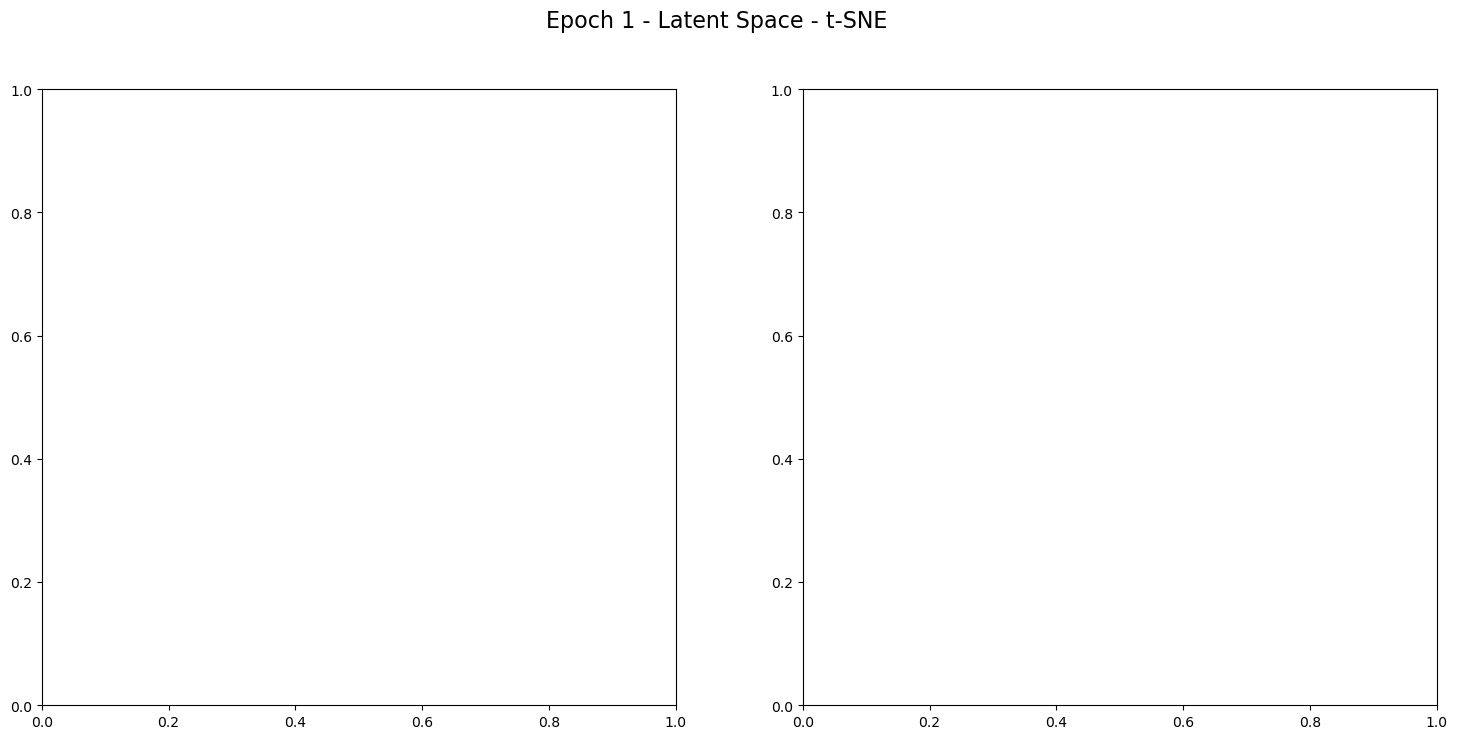

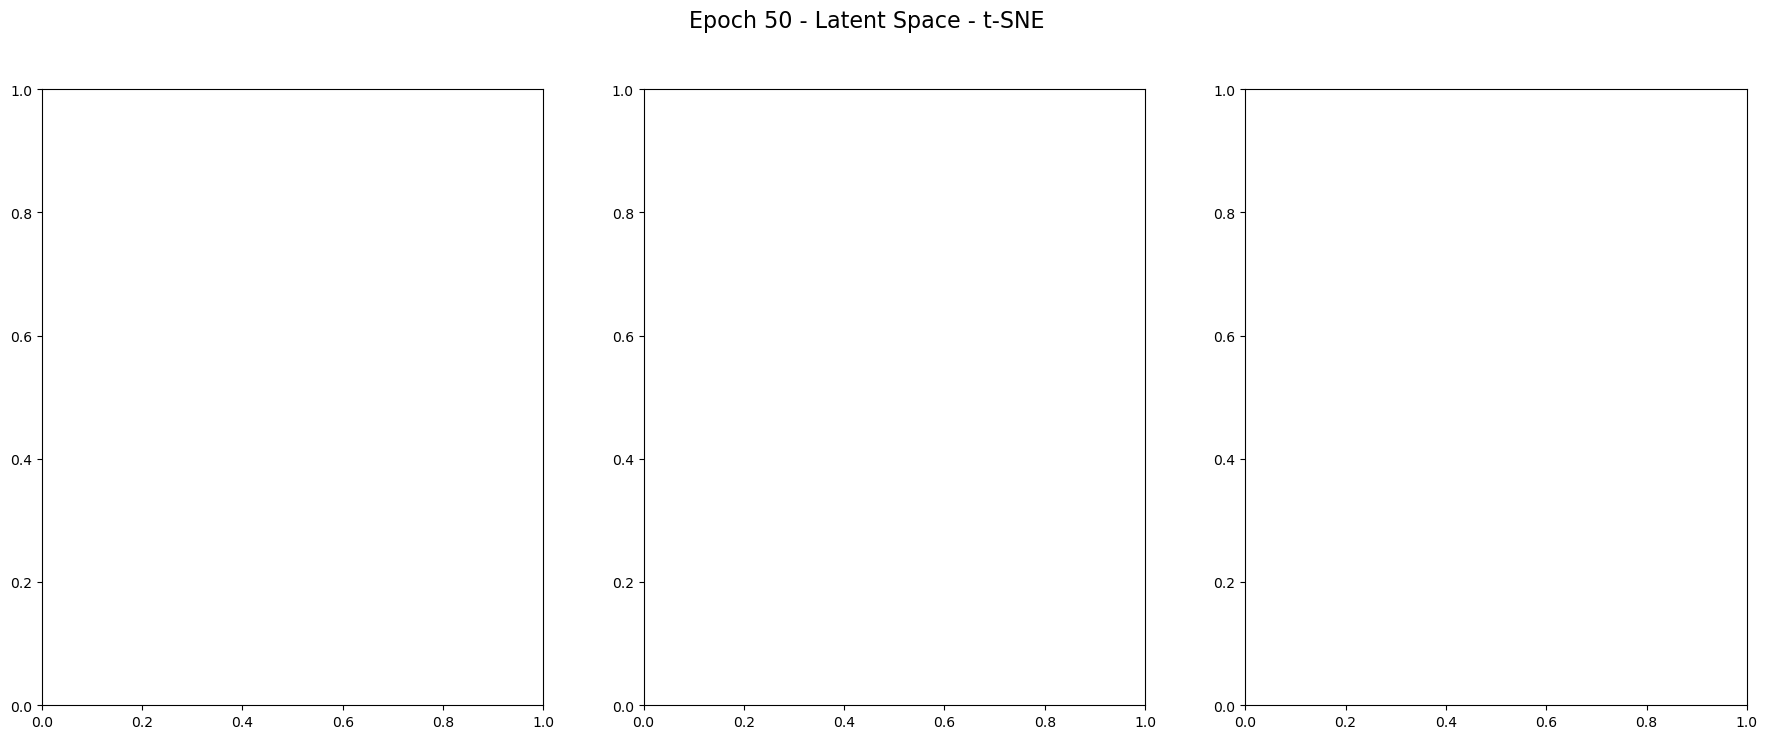

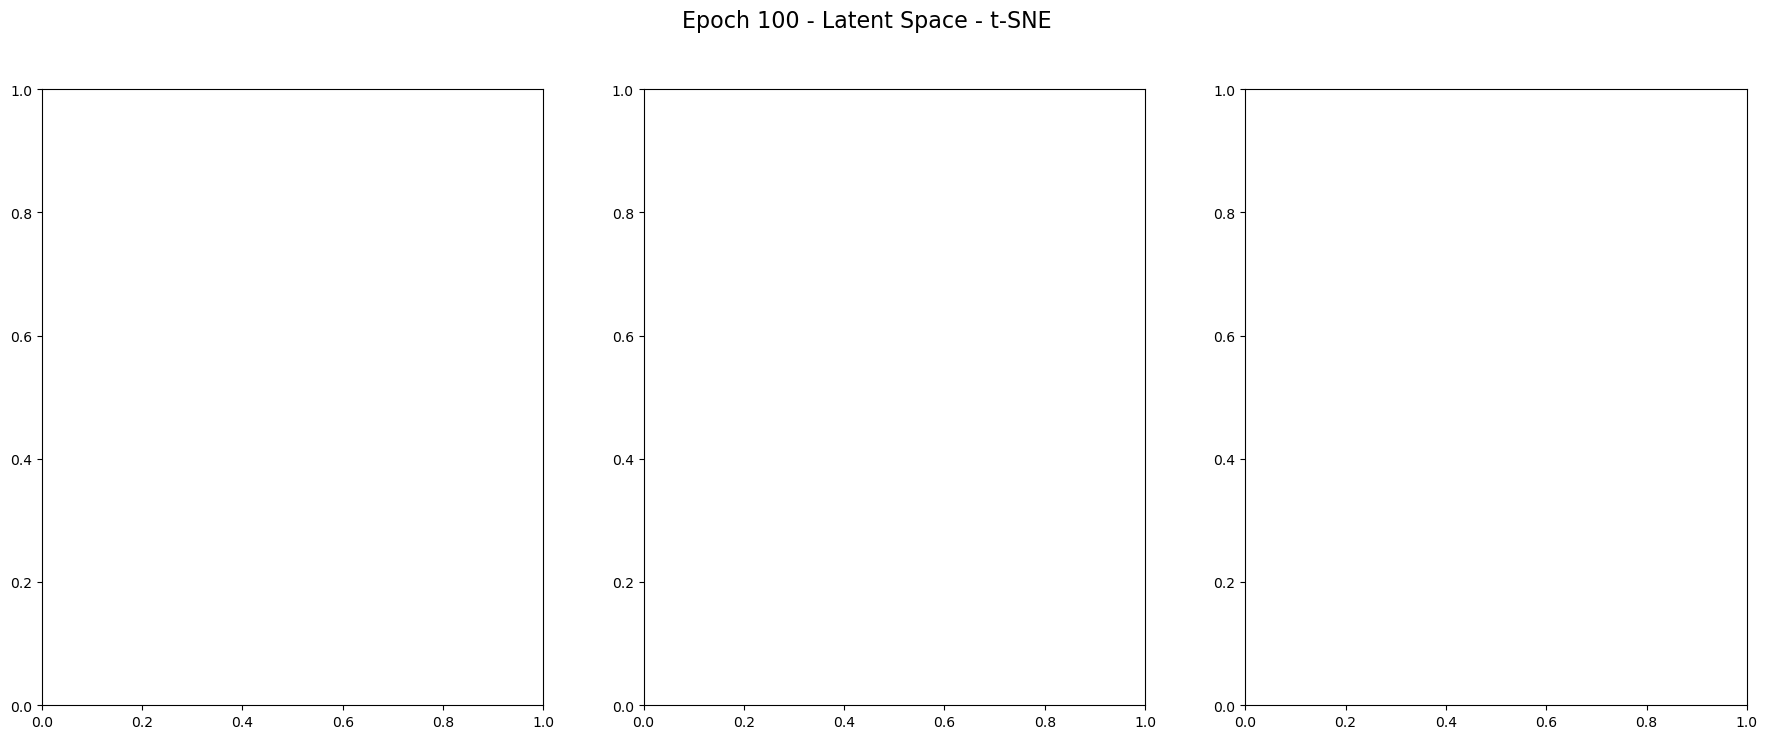

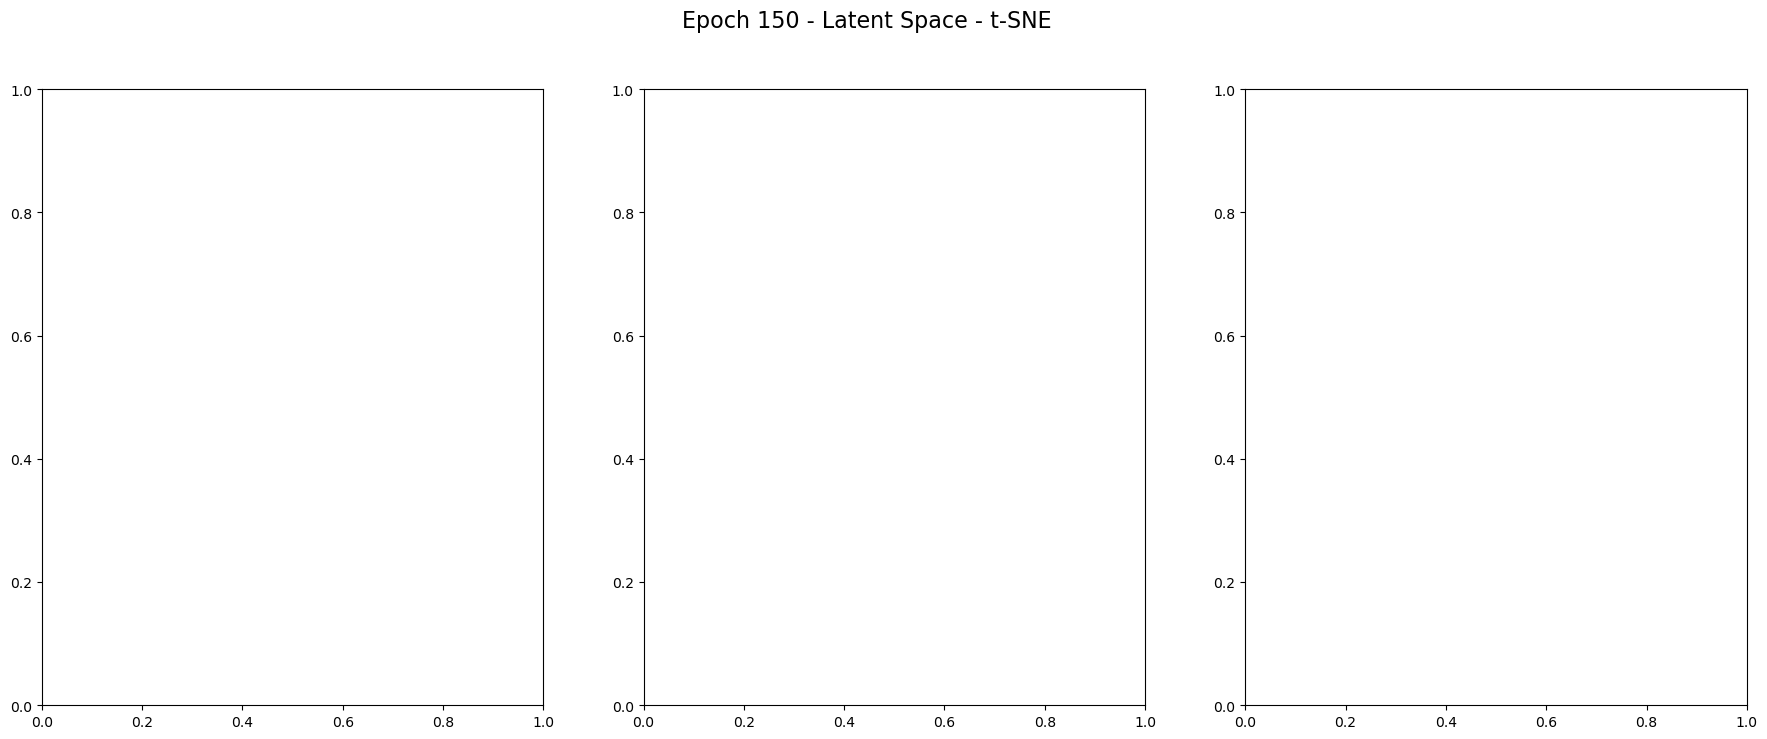

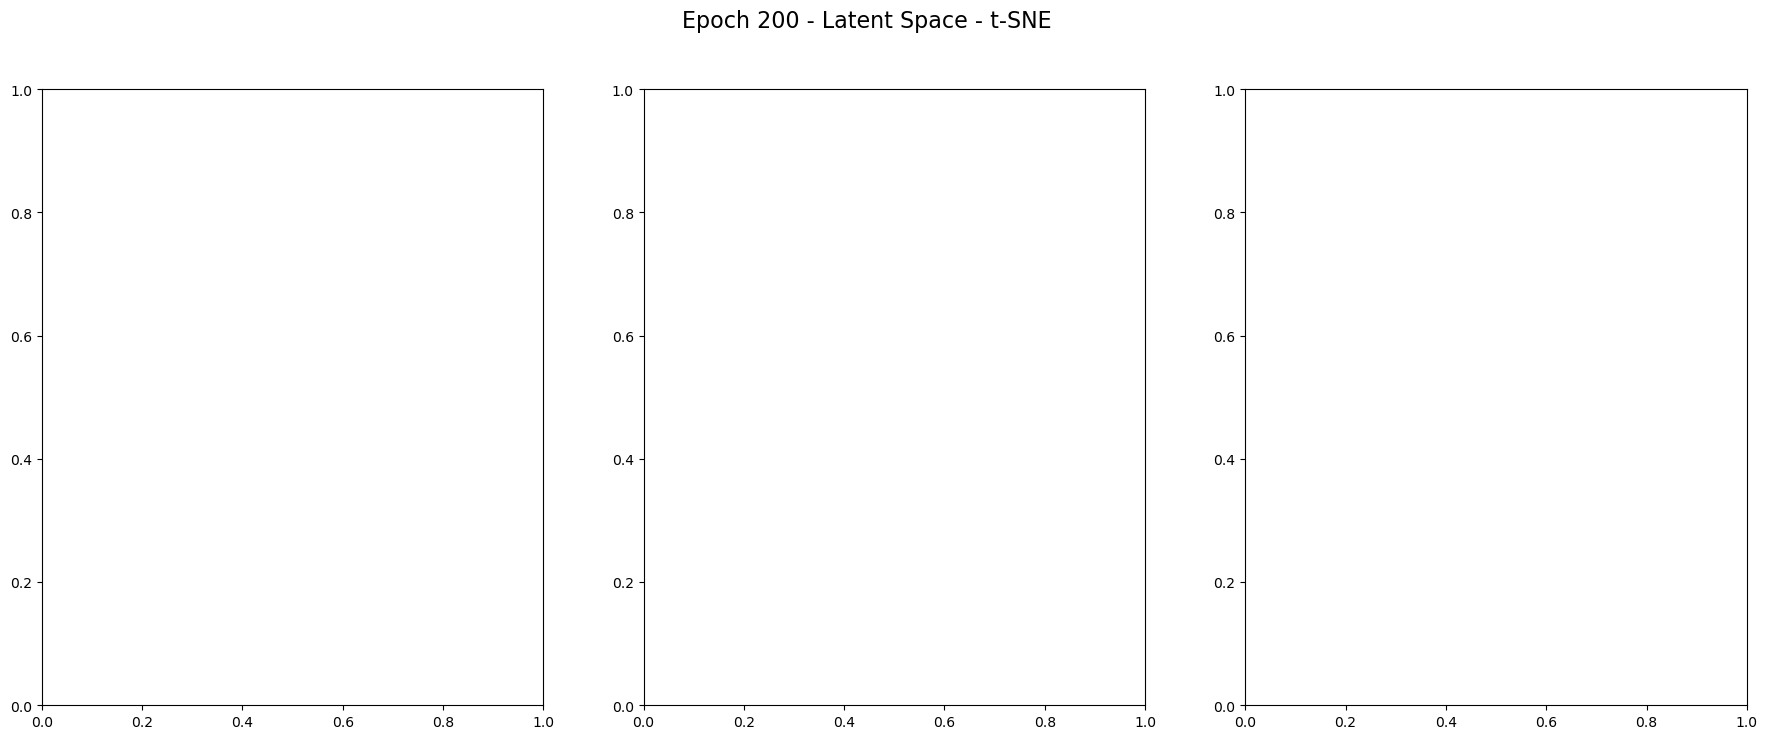

In [6]:
# Start training!
print("🚀 Starting DGD training...")
print("=" * 60)

# Record start time
training_start_time = time.time()

# Run the training process
# The trainer.train() method handles:
# - Model component creation (decoder, representation layers, GMM)
# - Optimizer setup and configuration
# - Training loop with progress tracking
# - GMM fitting at specified intervals
# - Loss computation and logging
# - Visualization generation and saving
# - ClearML metric logging

try:
    results = trainer.train(
        train_loader=train_loader,
        test_loader=test_loader,
        sample_data=sample_data,
        class_names=class_names
    )
    
    training_end_time = time.time()
    total_training_time = training_end_time - training_start_time
    
    print("\\n" + "=" * 60)
    print("🎉 Training completed successfully!")
    print(f"⏱️ Total training time: {total_training_time:.2f} seconds ({total_training_time/60:.2f} minutes)")
    
    # Extract results
    model = results['model']
    rep_layer = results['rep']
    test_rep_layer = results['test_rep']
    gmm = results['gmm']
    train_losses = results['train_losses']
    test_losses = results['test_losses']
    
    print(f"\\n📊 Final Results:")
    print(f"  Final train loss: {results['final_train_loss']:.6f}")
    print(f"  Final test loss: {results['final_test_loss']:.6f}")
    print(f"  Best train loss: {min(train_losses):.6f} (epoch {train_losses.index(min(train_losses)) + 1})")
    print(f"  Best test loss: {min(test_losses):.6f} (epoch {test_losses.index(min(test_losses)) + 1})")
    
    # Model information
    decoder_params = sum(p.numel() for p in model.decoder.parameters() if p.requires_grad)
    rep_params = sum(p.numel() for p in rep_layer.parameters() if p.requires_grad)
    test_rep_params = sum(p.numel() for p in test_rep_layer.parameters() if p.requires_grad)
    total_params = decoder_params + rep_params + test_rep_params
    
    print(f"\\n🏗️ Model Statistics:")
    print(f"  Decoder parameters: {decoder_params:,} ({decoder_params/1e6:.2f}M)")
    print(f"  Train representation parameters: {rep_params:,} ({rep_params/1e6:.2f}M)")
    print(f"  Test representation parameters: {test_rep_params:,} ({test_rep_params/1e6:.2f}M)")
    print(f"  Total parameters: {total_params:,} ({total_params/1e6:.2f}M)")
    
    print(f"\\n🎯 GMM Information:")
    print(f"  Number of components: {gmm.n_components}")
    print(f"  Covariance type: {gmm.covariance_type}")
    print(f"  Converged: {gmm.converged_}")
    print(f"  Number of iterations: {gmm.n_iter_}")
    
except Exception as e:
    print(f"❌ Training failed with error: {e}")
    import traceback
    traceback.print_exc()
    raise e

print("\\n✅ Training phase completed!")

## 7. Analyze Training Results

Let's analyze the training results by examining loss curves, reconstruction quality, and model performance.

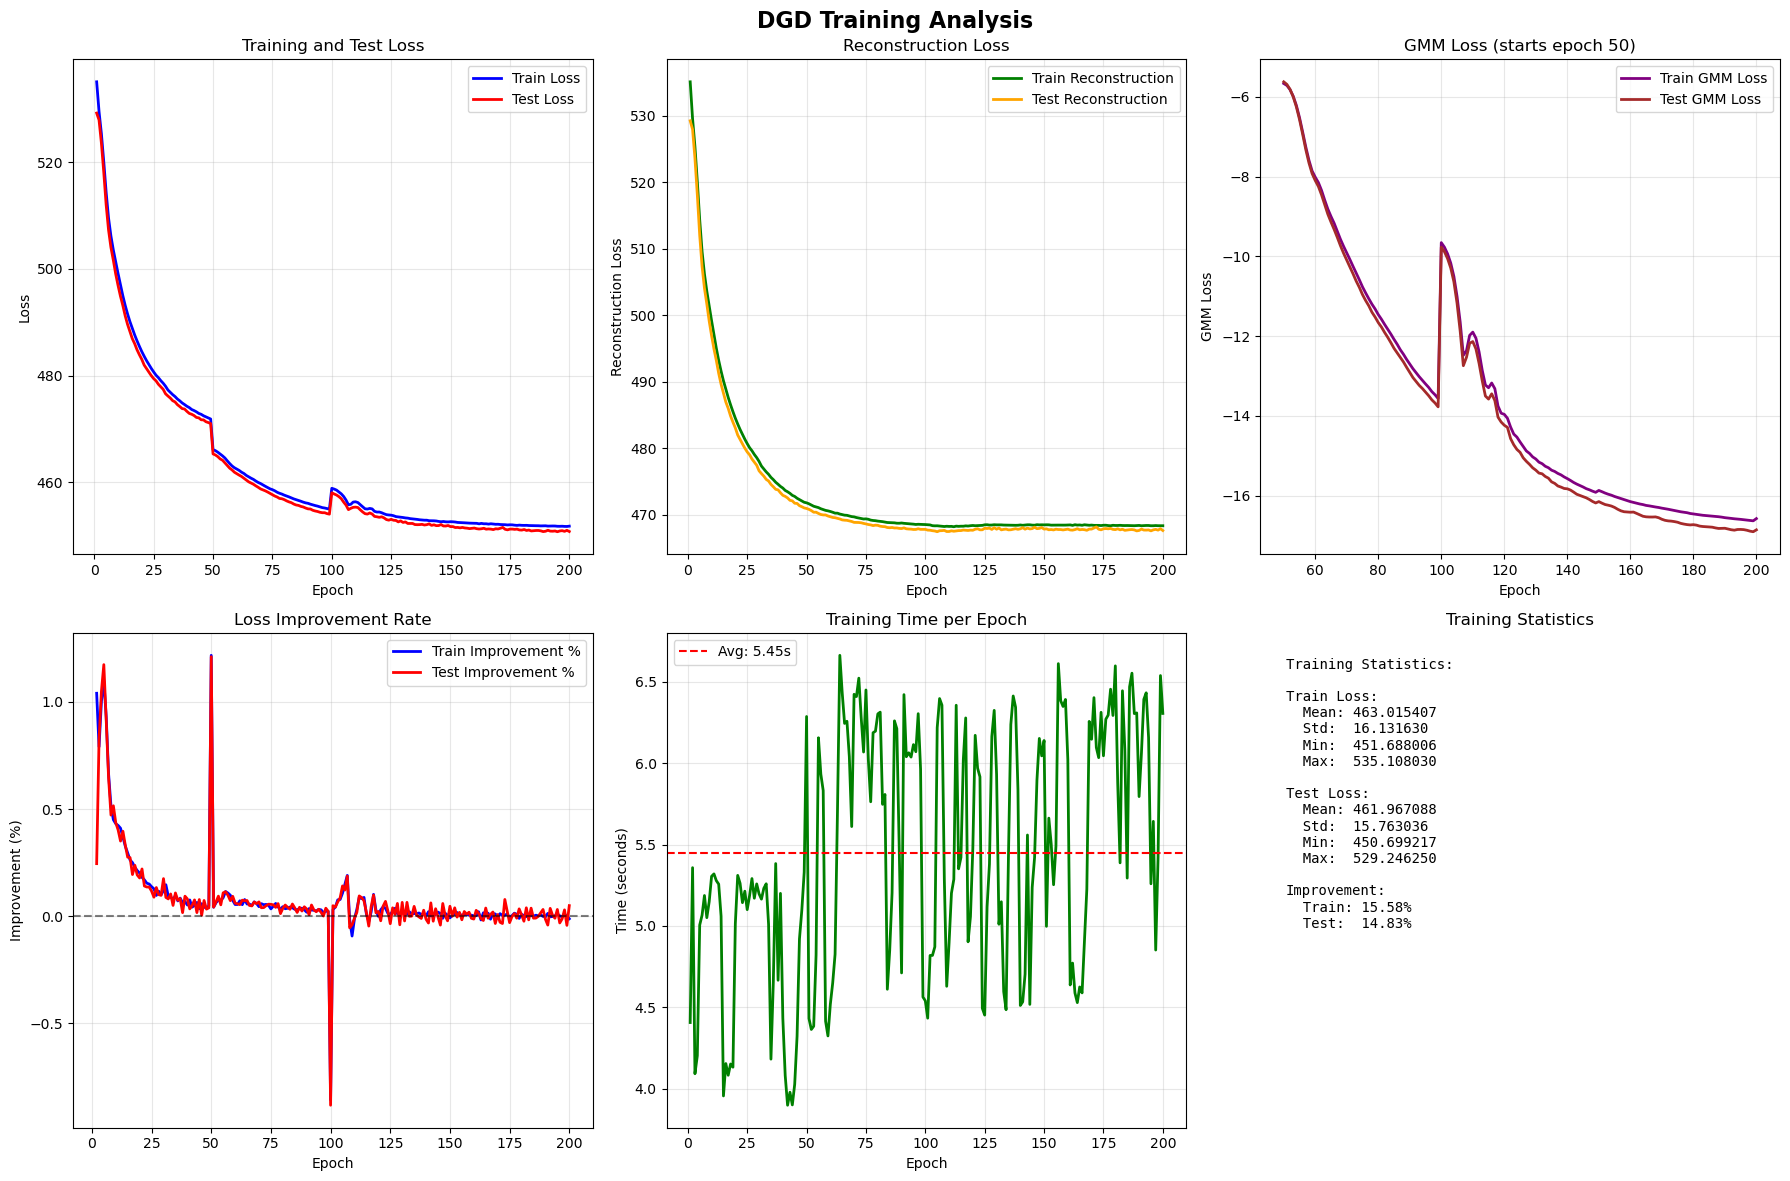

📊 Training Analysis Complete!
✓ Total epochs: 200
✓ Training improvement: 15.58%
✓ Test improvement: 14.83%
✓ Average epoch time: 5.45 seconds
✓ GMM fitted: Yes


In [7]:
# Plot comprehensive training analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('DGD Training Analysis', fontsize=16, fontweight='bold')

# 1. Training and Test Loss
axes[0, 0].plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Train Loss', linewidth=2)
axes[0, 0].plot(range(1, len(test_losses) + 1), test_losses, 'r-', label='Test Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Test Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Reconstruction Losses
recon_train_losses = trainer.recon_train_losses
recon_test_losses = trainer.recon_test_losses
axes[0, 1].plot(range(1, len(recon_train_losses) + 1), recon_train_losses, 'g-', label='Train Reconstruction', linewidth=2)
axes[0, 1].plot(range(1, len(recon_test_losses) + 1), recon_test_losses, 'orange', label='Test Reconstruction', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Reconstruction Loss')
axes[0, 1].set_title('Reconstruction Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. GMM Losses (after GMM starts)
gmm_train_losses = trainer.gmm_train_losses
gmm_test_losses = trainer.gmm_test_losses
gmm_start_epoch = config.training.first_epoch_gmm

if len(gmm_train_losses) > 0 and any(x != 0 for x in gmm_train_losses):
    non_zero_epochs = [i+1 for i, x in enumerate(gmm_train_losses) if x != 0]
    non_zero_train = [x for x in gmm_train_losses if x != 0]
    non_zero_test = [gmm_test_losses[i] for i, x in enumerate(gmm_train_losses) if x != 0]
    
    axes[0, 2].plot(non_zero_epochs, non_zero_train, 'purple', label='Train GMM Loss', linewidth=2)
    axes[0, 2].plot(non_zero_epochs, non_zero_test, 'brown', label='Test GMM Loss', linewidth=2)
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('GMM Loss')
    axes[0, 2].set_title(f'GMM Loss (starts epoch {gmm_start_epoch})')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
else:
    axes[0, 2].text(0.5, 0.5, 'GMM not fitted yet\\nor no GMM loss', ha='center', va='center', transform=axes[0, 2].transAxes)
    axes[0, 2].set_title('GMM Loss')

# 4. Loss Improvement Rate
if len(train_losses) > 1:
    train_improvements = [((train_losses[i-1] - train_losses[i]) / train_losses[i-1] * 100) if train_losses[i-1] != 0 else 0 
                         for i in range(1, len(train_losses))]
    test_improvements = [((test_losses[i-1] - test_losses[i]) / test_losses[i-1] * 100) if test_losses[i-1] != 0 else 0 
                        for i in range(1, len(test_losses))]
    
    axes[1, 0].plot(range(2, len(train_losses) + 1), train_improvements, 'b-', label='Train Improvement %', linewidth=2)
    axes[1, 0].plot(range(2, len(test_losses) + 1), test_improvements, 'r-', label='Test Improvement %', linewidth=2)
    axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Improvement (%)')
    axes[1, 0].set_title('Loss Improvement Rate')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

# 5. Epoch Times
epoch_times = trainer.epoch_times
if len(epoch_times) > 0:
    axes[1, 1].plot(range(1, len(epoch_times) + 1), epoch_times, 'green', linewidth=2)
    axes[1, 1].axhline(y=np.mean(epoch_times), color='red', linestyle='--', label=f'Avg: {np.mean(epoch_times):.2f}s')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Time (seconds)')
    axes[1, 1].set_title('Training Time per Epoch')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

# 6. Loss Summary Statistics
train_mean = np.mean(train_losses)
train_std = np.std(train_losses)
test_mean = np.mean(test_losses)
test_std = np.std(test_losses)

stats_text = f"""Training Statistics:

Train Loss:
  Mean: {train_mean:.6f}
  Std:  {train_std:.6f}
  Min:  {min(train_losses):.6f}
  Max:  {max(train_losses):.6f}

Test Loss:
  Mean: {test_mean:.6f}
  Std:  {test_std:.6f}
  Min:  {min(test_losses):.6f}
  Max:  {max(test_losses):.6f}

Improvement:
  Train: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.2f}%
  Test:  {((test_losses[0] - test_losses[-1]) / test_losses[0] * 100):.2f}%
"""

axes[1, 2].text(0.05, 0.95, stats_text, transform=axes[1, 2].transAxes, fontsize=10, 
                verticalalignment='top', fontfamily='monospace')
axes[1, 2].set_title('Training Statistics')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("📊 Training Analysis Complete!")
print(f"✓ Total epochs: {len(train_losses)}")
print(f"✓ Training improvement: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.2f}%")
print(f"✓ Test improvement: {((test_losses[0] - test_losses[-1]) / test_losses[0] * 100):.2f}%")
print(f"✓ Average epoch time: {np.mean(epoch_times):.2f} seconds")
print(f"✓ GMM fitted: {'Yes' if gmm.converged_ else 'No'}")

## 8. Model Evaluation and Testing

Let's evaluate the trained model by examining reconstruction quality and computing various metrics.

🔍 Evaluating trained DGD model...
✓ Reconstruction MSE - Train: 0.636483 ± 0.139055
✓ Reconstruction MSE - Test: 0.669177 ± 0.154310


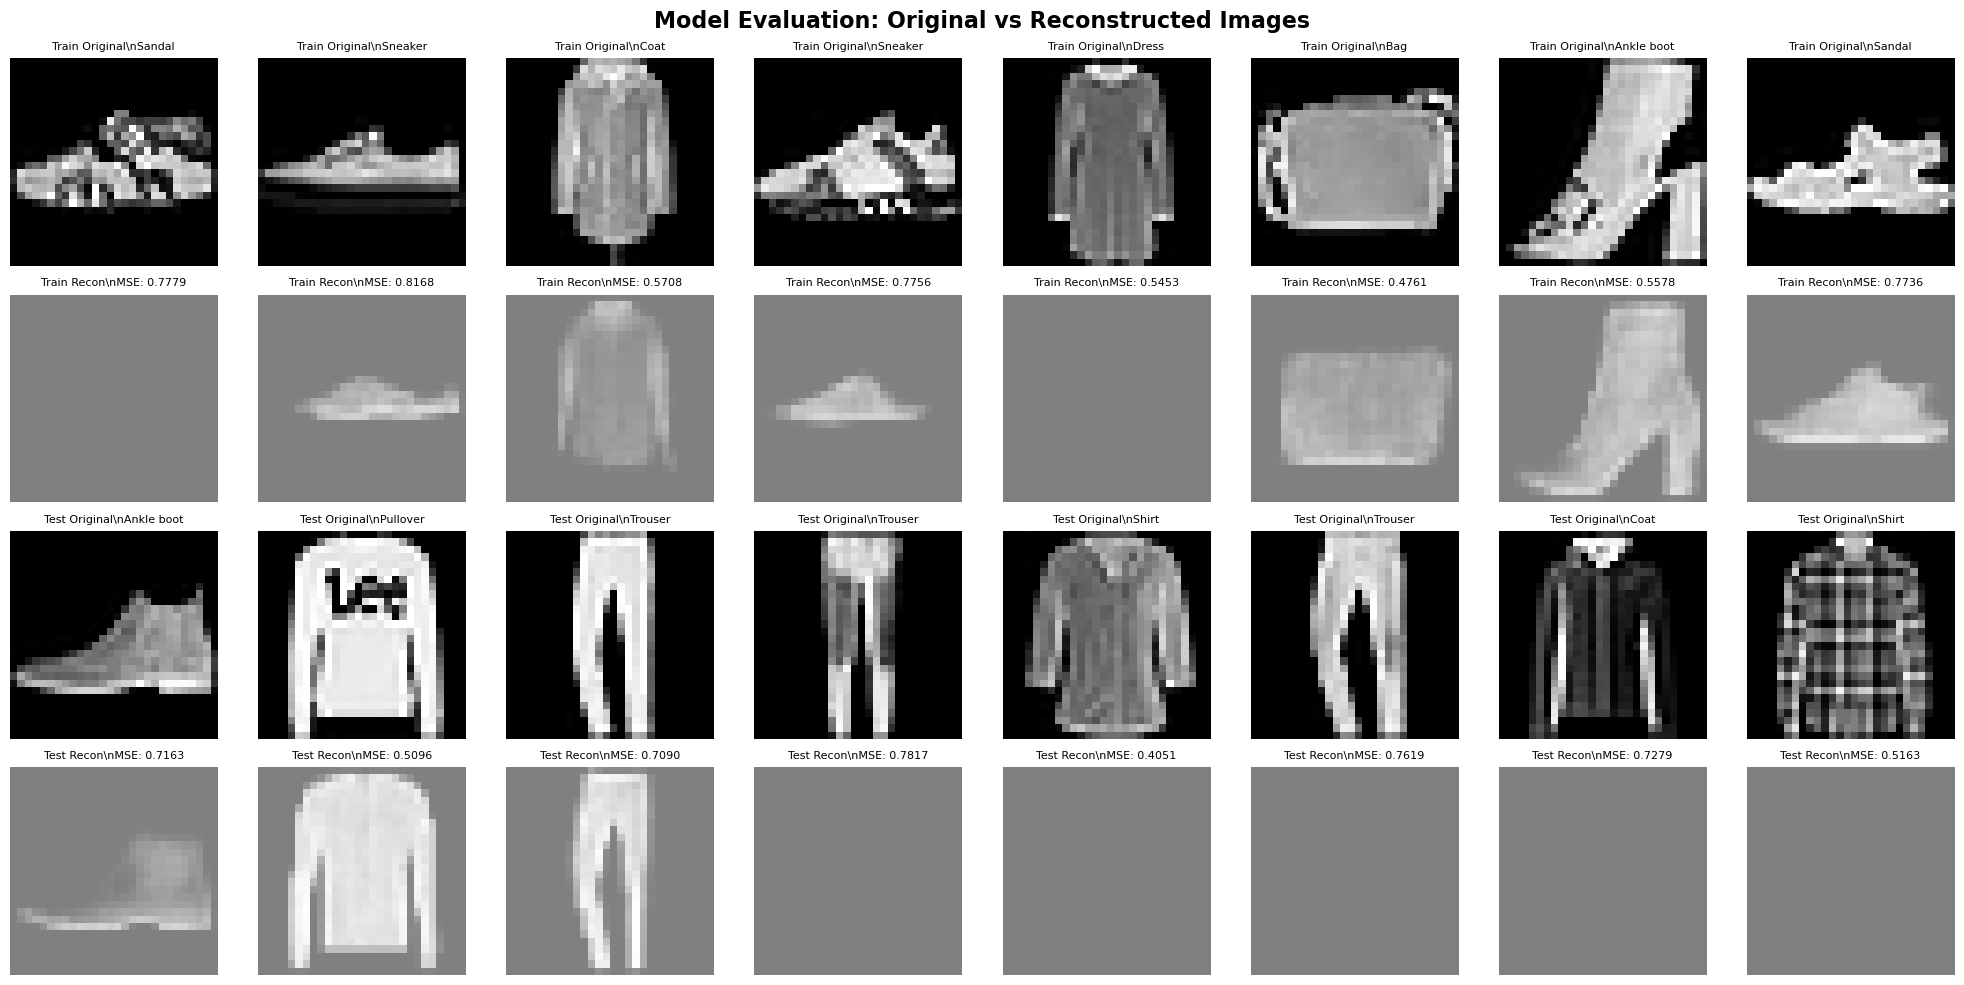

\n📊 Comprehensive Model Evaluation:
\n🎯 Reconstruction Quality:
  Train samples: 60000
  Test samples: 10000
  Sample train MSE: 0.636483 ± 0.139055
  Sample test MSE: 0.669177 ± 0.154310
\n🌌 Latent Space Analysis:
  Latent dimension: 5
  Train latent norm: 0.1534 ± 0.0664
  Test latent norm: 0.1991 ± 0.0584
  Latent range: [-0.179, 0.114]
\n🎲 GMM Evaluation:
  Number of components: 20
  Covariance type: spherical
  Converged: True
  Iterations: 13
  Train log-likelihood: 16.3839 ± 7.6187
  Test log-likelihood: 22.1789 ± 8.4545
  Component weights: tensor([0.0294, 0.1331, 0.0359, 0.0077, 0.0353, 0.3130, 0.0265, 0.0411, 0.0151,
        0.0536, 0.0052, 0.0214, 0.0029, 0.0759, 0.0214, 0.0167, 0.0300, 0.0568,
        0.0417, 0.0375], device='cuda:1')
  Effective components: 17 / 20
\n✅ Model evaluation completed!


In [8]:
# Evaluate the trained model
print("🔍 Evaluating trained DGD model...")

# Set model to evaluation mode
model.eval()

# Test reconstruction quality on sample data
with torch.no_grad():
    # Get sample data
    indices_train, images_train, labels_train, indices_test, images_test, labels_test = sample_data
    
    # Move to device
    indices_train = indices_train.to(device)
    images_train = images_train.to(device)
    indices_test = indices_test.to(device)
    images_test = images_test.to(device)
    
    # Generate reconstructions
    z_train = rep_layer(indices_train)
    recon_train = model.decoder(z_train)
    
    z_test = test_rep_layer(indices_test)
    recon_test = model.decoder(z_test)
    
    # Compute reconstruction errors
    train_mse = F.mse_loss(recon_train, images_train, reduction='none').mean(dim=[1,2,3])
    test_mse = F.mse_loss(recon_test, images_test, reduction='none').mean(dim=[1,2,3])
    
    print(f"✓ Reconstruction MSE - Train: {train_mse.mean():.6f} ± {train_mse.std():.6f}")
    print(f"✓ Reconstruction MSE - Test: {test_mse.mean():.6f} ± {test_mse.std():.6f}")

# Visualize reconstructions
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
fig.suptitle('Model Evaluation: Original vs Reconstructed Images', fontsize=16, fontweight='bold')

# Convert tensors to CPU and numpy for plotting
images_train_cpu = images_train.cpu()
recon_train_cpu = recon_train.cpu()
images_test_cpu = images_test.cpu()
recon_test_cpu = recon_test.cpu()
labels_train_cpu = labels_train.cpu()
labels_test_cpu = labels_test.cpu()

for i in range(8):
    # Original train images
    img = images_train_cpu[i].squeeze()
    img = (img + 1) / 2  # Denormalize from [-1,1] to [0,1]
    label = labels_train_cpu[i].item()
    axes[0, i].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[0, i].set_title(f'Train Original\\n{class_names[label]}', fontsize=8)
    axes[0, i].axis('off')
    
    # Reconstructed train images
    img = recon_train_cpu[i].squeeze()
    img = torch.clamp((img + 1) / 2, 0, 1)  # Denormalize and clamp
    mse = train_mse[i].item()
    axes[1, i].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[1, i].set_title(f'Train Recon\\nMSE: {mse:.4f}', fontsize=8)
    axes[1, i].axis('off')
    
    # Original test images
    img = images_test_cpu[i].squeeze()
    img = (img + 1) / 2  # Denormalize from [-1,1] to [0,1]
    label = labels_test_cpu[i].item()
    axes[2, i].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[2, i].set_title(f'Test Original\\n{class_names[label]}', fontsize=8)
    axes[2, i].axis('off')
    
    # Reconstructed test images
    img = recon_test_cpu[i].squeeze()
    img = torch.clamp((img + 1) / 2, 0, 1)  # Denormalize and clamp
    mse = test_mse[i].item()
    axes[3, i].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[3, i].set_title(f'Test Recon\\nMSE: {mse:.4f}', fontsize=8)
    axes[3, i].axis('off')

plt.tight_layout()
plt.show()

# Compute comprehensive evaluation metrics
print("\\n📊 Comprehensive Model Evaluation:")

# 1. Overall reconstruction quality
total_train_samples = len(train_loader.dataset)
total_test_samples = len(test_loader.dataset)

print(f"\\n🎯 Reconstruction Quality:")
print(f"  Train samples: {total_train_samples}")
print(f"  Test samples: {total_test_samples}")
print(f"  Sample train MSE: {train_mse.mean():.6f} ± {train_mse.std():.6f}")
print(f"  Sample test MSE: {test_mse.mean():.6f} ± {test_mse.std():.6f}")

# 2. Latent space analysis
z_train_norm = torch.norm(z_train, dim=1)
z_test_norm = torch.norm(z_test, dim=1)

print(f"\\n🌌 Latent Space Analysis:")
print(f"  Latent dimension: {z_train.shape[1]}")
print(f"  Train latent norm: {z_train_norm.mean():.4f} ± {z_train_norm.std():.4f}")
print(f"  Test latent norm: {z_test_norm.mean():.4f} ± {z_test_norm.std():.4f}")
print(f"  Latent range: [{z_train.min():.3f}, {z_train.max():.3f}]")

# 3. GMM evaluation
if gmm.converged_:
    # Compute log-likelihood of representations
    train_log_likelihood = gmm.score_samples(z_train)
    test_log_likelihood = gmm.score_samples(z_test)
    
    print(f"\\n🎲 GMM Evaluation:")
    print(f"  Number of components: {gmm.n_components}")
    print(f"  Covariance type: {gmm.covariance_type}")
    print(f"  Converged: {gmm.converged_}")
    print(f"  Iterations: {gmm.n_iter_}")
    print(f"  Train log-likelihood: {train_log_likelihood.mean():.4f} ± {train_log_likelihood.std():.4f}")
    print(f"  Test log-likelihood: {test_log_likelihood.mean():.4f} ± {test_log_likelihood.std():.4f}")
    
    # Component weights
    weights = gmm.weights_
    print(f"  Component weights: {weights}")
    print(f"  Effective components: {(weights > 0.01).sum()} / {len(weights)}")
else:
    print(f"\\n⚠️ GMM did not converge (iterations: {gmm.n_iter_})")

print("\\n✅ Model evaluation completed!")

## 9. Generate Samples from Trained Model

Now let's generate new samples using the trained GMM and explore the latent space capabilities.

🎨 Generating samples from trained DGD model...
✓ Generated 32 samples from GMM
✓ Sample shape: torch.Size([32, 1, 28, 28])
✓ Component distribution: [1 3 0 0 0 8 2 2 1 2 0 1 0 5 0 1 1 2 1 2]


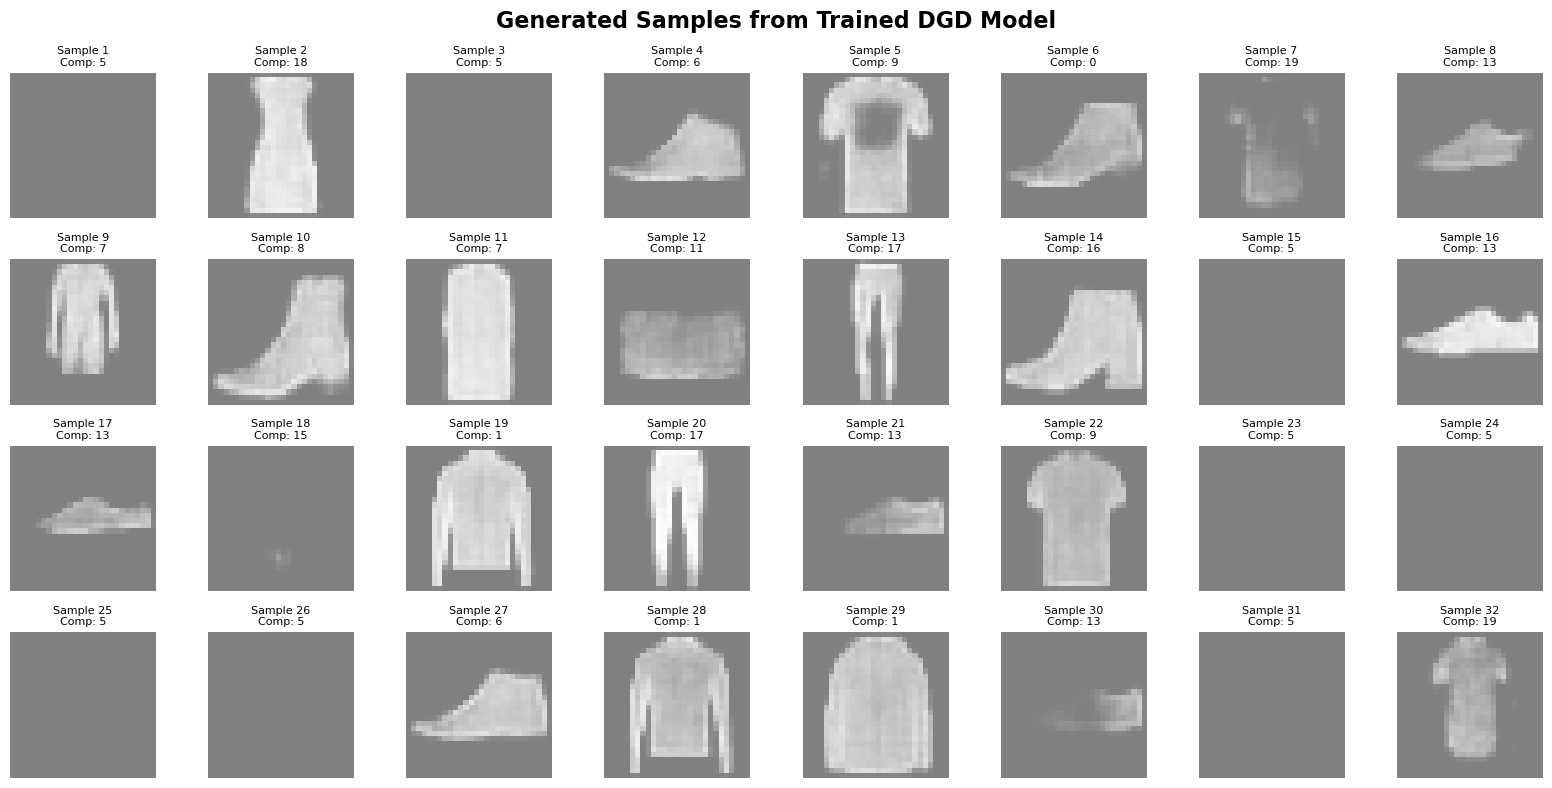


🎯 Generating samples from individual GMM components...


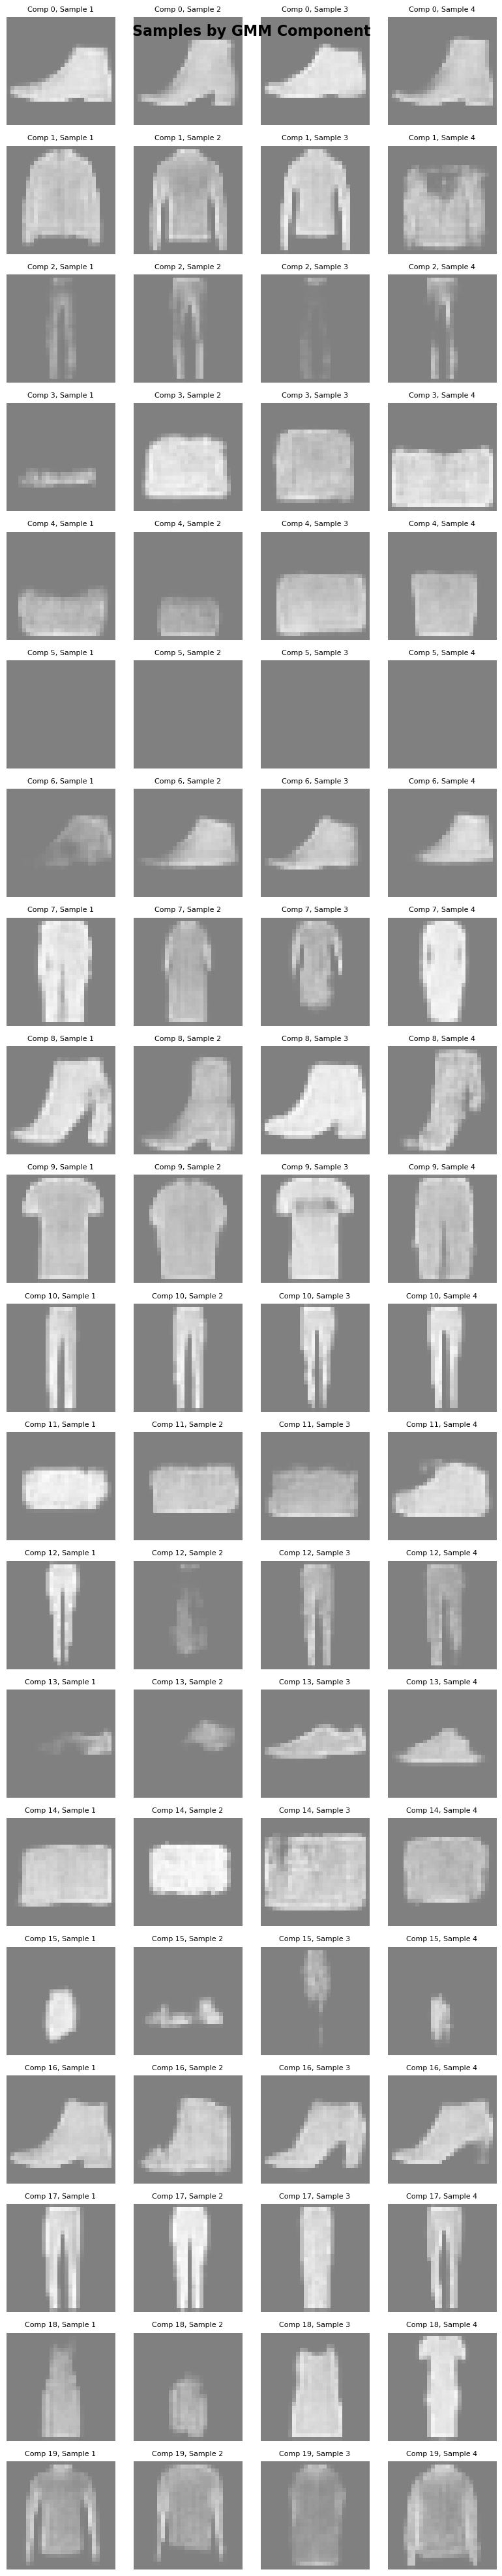

In [11]:
# Generate samples from the trained model
print("🎨 Generating samples from trained DGD model...")

if gmm.converged_:
    with torch.no_grad():
        # 1. Sample from GMM
        n_samples = 32
        z_samples, component_labels = gmm.sample(n_samples)
        
        # Generate images from samples
        generated_images = model.decoder(z_samples)
        
        print(f"✓ Generated {n_samples} samples from GMM")
        print(f"✓ Sample shape: {generated_images.shape}")
        print(f"✓ Component distribution: {np.bincount(component_labels.cpu().numpy())}")
        
        # Visualize generated samples
        fig, axes = plt.subplots(4, 8, figsize=(16, 8))
        fig.suptitle('Generated Samples from Trained DGD Model', fontsize=16, fontweight='bold')
        
        generated_images_cpu = generated_images.cpu()
        component_labels_cpu = component_labels.cpu()
        
        for i in range(min(32, n_samples)):
            row = i // 8
            col = i % 8
            
            img = generated_images_cpu[i].squeeze()
            img = torch.clamp((img + 1) / 2, 0, 1)  # Denormalize and clamp
            component = component_labels_cpu[i].item()
            
            axes[row, col].imshow(img, cmap='gray', vmin=0, vmax=1)
            axes[row, col].set_title(f'Sample {i+1}\nComp: {component}', fontsize=8)
            axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # 2. Sample from each GMM component separately
        print("\n🎯 Generating samples from individual GMM components...")
        
        def sample_from_component(gmm, n_samples, component_idx):
            """Sample n_samples from a specific GMM component."""
            # Get the mean and covariance for the specific component
            mean = gmm.means_[component_idx]
            
            # Handle different covariance types
            if gmm.covariance_type == 'full':
                cov = gmm.covariances_[component_idx]
            elif gmm.covariance_type == 'diag':
                cov = torch.diag_embed(gmm.covariances_[component_idx])
            elif gmm.covariance_type == 'spherical':
                cov = torch.eye(gmm.n_features, device=gmm.device) * gmm.covariances_[component_idx]
            elif gmm.covariance_type == 'tied_full':
                cov = gmm.covariances_
            elif gmm.covariance_type == 'tied_diag':
                cov = torch.diag_embed(gmm.covariances_)
            elif gmm.covariance_type == 'tied_spherical':
                cov = torch.eye(gmm.n_features, device=gmm.device) * gmm.covariances_
            else:
                raise ValueError(f"Unsupported covariance type: {gmm.covariance_type}")
            
            # Sample from the multivariate normal distribution
            dist = torch.distributions.MultivariateNormal(mean, cov)
            samples = dist.sample((n_samples,))
            return samples
        
        # Generate samples from each component
        n_per_component = 4
        fig, axes = plt.subplots(gmm.n_components, n_per_component, figsize=(n_per_component*2, gmm.n_components*2))
        fig.suptitle('Samples by GMM Component', fontsize=16, fontweight='bold')
        
        for comp in range(gmm.n_components):
            # Sample from specific component
            z_comp = sample_from_component(gmm, n_per_component, comp)
            imgs_comp = model.decoder(z_comp)
            
            for j in range(n_per_component):
                img = imgs_comp[j].cpu().squeeze()
                img = torch.clamp((img + 1) / 2, 0, 1)
                
                if gmm.n_components == 1:
                    axes[j].imshow(img, cmap='gray', vmin=0, vmax=1)
                    axes[j].set_title(f'Comp {comp}, Sample {j+1}', fontsize=8)
                    axes[j].axis('off')
                else:
                    axes[comp, j].imshow(img, cmap='gray', vmin=0, vmax=1)
                    axes[comp, j].set_title(f'Comp {comp}, Sample {j+1}', fontsize=8)
                    axes[comp, j].axis('off')
        
        plt.tight_layout()
        plt.show()
        
else:
    print("⚠️ GMM did not converge - cannot generate meaningful samples")
    print("💡 Try training for more epochs or adjusting GMM parameters")

## 10. Save and Export Model

Finally, let's save the trained model components and demonstrate how to load them for future use.

In [10]:
# Save the trained model components
print("💾 Saving trained DGD model components...")

# Create model save directory
model_dir = project_root / "models" / "dgd_demo"
model_dir.mkdir(parents=True, exist_ok=True)

print(f"Model save directory: {model_dir}")

# 1. Save model state dictionaries
torch.save(model.decoder.state_dict(), model_dir / "decoder.pth")
torch.save(rep_layer.state_dict(), model_dir / "train_representation.pth")
torch.save(test_rep_layer.state_dict(), model_dir / "test_representation.pth")

print("✓ Saved PyTorch model state dictionaries")

# 2. Save GMM model
import pickle
with open(model_dir / "gmm.pkl", "wb") as f:
    pickle.dump(gmm, f)

print("✓ Saved GMM model")

# 3. Save configuration
OmegaConf.save(config, model_dir / "config.yaml")

print("✓ Saved configuration")

# 4. Save training results
training_results = {
    'train_losses': train_losses,
    'test_losses': test_losses,
    'recon_train_losses': trainer.recon_train_losses,
    'recon_test_losses': trainer.recon_test_losses,
    'gmm_train_losses': trainer.gmm_train_losses,
    'gmm_test_losses': trainer.gmm_test_losses,
    'epoch_times': trainer.epoch_times,
    'final_train_loss': results['final_train_loss'],
    'final_test_loss': results['final_test_loss'],
    'total_time': results['total_time']
}

torch.save(training_results, model_dir / "training_results.pth")

print("✓ Saved training results")

# 5. Save model metadata
metadata = {
    'model_type': 'DGD',
    'dataset': config.data.dataset,
    'epochs_trained': len(train_losses),
    'latent_dim': config.model.representation.n_features,
    'decoder_params': sum(p.numel() for p in model.decoder.parameters()),
    'rep_params': sum(p.numel() for p in rep_layer.parameters()),
    'gmm_components': gmm.n_components,
    'gmm_converged': gmm.converged_,
    'training_date': time.strftime('%Y-%m-%d %H:%M:%S'),
    'device_used': str(device),
    'pytorch_version': torch.__version__
}

torch.save(metadata, model_dir / "metadata.pth")

print("✓ Saved model metadata")

# List all saved files
saved_files = list(model_dir.glob("*"))
print(f"\\n📁 Saved files ({len(saved_files)} total):")
for file in saved_files:
    size_mb = file.stat().st_size / (1024 * 1024)
    print(f"  {file.name}: {size_mb:.2f} MB")

print("\\n" + "="*60)
print("🔄 Demonstrating Model Loading...")

# Demonstrate loading the saved model
def load_dgd_model(model_dir, device):
    """Load a saved DGD model from directory."""
    print(f"Loading DGD model from {model_dir}...")
    
    # Load configuration
    config_loaded = OmegaConf.load(model_dir / "config.yaml")
    
    # Load metadata
    metadata = torch.load(model_dir / "metadata.pth", map_location=device)
    
    # Recreate decoder
    decoder_loaded = ConvDecoder(
        latent_dim=config_loaded.model.representation.n_features,
        hidden_dims=config_loaded.model.decoder.hidden_dims,
        output_channels=config_loaded.model.decoder.output_channels,
        output_size=config_loaded.model.decoder.output_size,
        use_batch_norm=config_loaded.model.decoder.use_batch_norm,
        activation=config_loaded.model.decoder.activation,
        final_activation=config_loaded.model.decoder.final_activation,
        dropout_rate=config_loaded.model.decoder.dropout_rate,
        init_size=config_loaded.model.decoder.init_size
    ).to(device)
    
    # Load decoder weights
    decoder_loaded.load_state_dict(torch.load(model_dir / "decoder.pth", map_location=device))
    
    # Load GMM
    with open(model_dir / "gmm.pkl", "rb") as f:
        gmm_loaded = pickle.load(f)
    
    # Recreate representation layers (for new data)
    rep_loaded = RepresentationLayer(
        dim=config_loaded.model.representation.n_features,
        n_samples=1000,  # Can be changed for new datasets
        dist=config_loaded.model.representation.distribution,
        dist_params={'radius': config_loaded.model.representation.radius} if hasattr(config_loaded.model.representation, 'radius') else {},
        device=device
    )
    
    # Create DGD model
    model_loaded = DGD(decoder_loaded, rep_loaded, gmm_loaded)
    
    print("✓ Model loaded successfully!")
    return model_loaded, config_loaded, metadata

# Load the model
loaded_model, loaded_config, loaded_metadata = load_dgd_model(model_dir, device)

print("✅ Model loading demonstration completed!")
print(f"✓ Loaded model trained for {loaded_metadata['epochs_trained']} epochs")
print(f"✓ Model parameters: {loaded_metadata['decoder_params']:,}")
print(f"✓ GMM converged: {loaded_metadata['gmm_converged']}")
print(f"✓ Training date: {loaded_metadata['training_date']}")

# Test the loaded model with a sample
print("\\n🧪 Testing loaded model...")
with torch.no_grad():
    # Sample from loaded GMM
    z_test_load, _ = loaded_model.gmm.sample(4)
    img_test_load = loaded_model.decoder(z_test_load)
    
    # Visualize
    fig, axes = plt.subplots(1, 4, figsize=(8, 2))
    fig.suptitle('Samples from Loaded Model', fontsize=12, fontweight='bold')
    
    for i in range(4):
        img = img_test_load[i].cpu().squeeze()
        img = torch.clamp((img + 1) / 2, 0, 1)
        axes[i].imshow(img, cmap='gray', vmin=0, vmax=1)
        axes[i].set_title(f'Sample {i+1}', fontsize=8)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("✓ Loaded model generates samples correctly!")

# Final summary
print("\\n" + "="*60)
print("🎉 DGD Training Demo Complete!")
print("="*60)
print("\\n📋 Summary:")
print(f"✅ Trained DGD model for {len(train_losses)} epochs")
print(f"✅ Final train loss: {results['final_train_loss']:.6f}")
print(f"✅ Final test loss: {results['final_test_loss']:.6f}")
print(f"✅ GMM fitted with {gmm.n_components} components")
print(f"✅ Model saved to: {model_dir}")
print(f"✅ Model loading verified")
print(f"✅ Sample generation working")

print("\\n🚀 Next Steps:")
print("• Try different configurations (latent dimensions, architectures)")
print("• Experiment with different datasets")
print("• Adjust GMM parameters for better clustering")
print("• Use longer training for better convergence")
print("• Explore different representation distributions")
print("• Use ClearML for experiment tracking and comparison")

if task:
    print(f"\\n📊 View results in ClearML: Task ID {task.id}")
    # Mark task as completed
    task.mark_completed()

print("\\n🎯 DGDTrainer Usage Demonstrated Successfully!")

💾 Saving trained DGD model components...
Model save directory: /maps/projects/heads/people/kbh904/ImageDGD/models/dgd_demo
✓ Saved PyTorch model state dictionaries
✓ Saved GMM model
✓ Saved configuration
✓ Saved training results
✓ Saved model metadata
\n📁 Saved files (7 total):
  decoder.pth: 0.94 MB
  config.yaml: 0.00 MB
  train_representation.pth: 1.15 MB
  gmm.pkl: 0.00 MB
  test_representation.pth: 0.19 MB
  training_results.pth: 0.01 MB
  metadata.pth: 0.00 MB
\n============================================================
🔄 Demonstrating Model Loading...
Loading DGD model from /maps/projects/heads/people/kbh904/ImageDGD/models/dgd_demo...


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torch.torch_version.TorchVersion was not an allowed global by default. Please use `torch.serialization.add_safe_globals([torch.torch_version.TorchVersion])` or the `torch.serialization.safe_globals([torch.torch_version.TorchVersion])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.